In [4]:
# first we shall create a sample model 

from Models.fifa_model_generation import get_fifa_model

# the function returns a trained fifa model
model_obj, x_dataset, y_dataset  = get_fifa_model()
model_obj

/opt/conda/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [12]:
"""Interpretation Class"""

import pandas as pd

class DevExplainer:
    """
    Interpretation class. Before calling interpretation subclasses like partial
    dependence, one must call Interpretation.load_data().
    Examples
    --------
        >>> from skater.core.explanations import Interpretation
        >>> interpreter = Interpretation()
        >>> interpreter.load_data(X, feature_ids = ['a','b'])
        >>> interpreter.partial_dependence([feature_id1, feature_id2], regressor.predict)
    """

    def __init__(self, model_obj, x_train, y_train, model_type="classification", log_level=50, features=None, selective_features=None, target=None, unique_values = None, prediction_fn=None, sample=False):
        self.model = self.verify_model(model_obj)
        self.x_train = self.verify_data(x_train)
        self.y_train = self.verify_data(y_train)
        self.model_type = self.verify_model_type(model_type)
        self.feature_names = self.verify_features(features)
        self.target_names = self.verify_target(target)
        self.unique_values = self.verify_unqiue(unique_values)
        self.prediction_fn = prediction_fn
        self.log_level = log_level
        self.interpreter = None
        self.inmemory_model = None
        self.sampling = sample
        self.selective_features = self.verify_selective_features(selective_features)
        
    def verify_selective_features(self, selective_features):
        
        if selective_features is not None:
            print("\nSelective Features : ", selective_features)
            return selective_features
        else:
            return self.feature_names
    
    def verify_model(self, model):
        print("\nModel Object Type : ", type(model))
        if type(model) != "str":
            print("Model Object Validated")
        else:
            raise TypeError('Please provide Proper Model Object')
        return model
            
    def verify_data(self, dataset):
        print("\nValidating dataset")
        print("Dataset Type : ", type(dataset))
        if isinstance(dataset, pd.DataFrame) or isinstance(dataset, pd.Series):
            return dataset
        else:
            raise TypeError('Please provide dataset of type: \nPandas Dataframe\nPandas series')
    
    def verify_model_type(self, model_type):
        print("\nValidating model type")
        print("Type entered :", model_type.lower())
        if model_type.lower() == "classification" or model_type.lower() == "regression":
            print("Model Type Validated")
            return model_type.lower()
        else:
            raise TypeError('Please provide model_type: \nClassification \nRegression')
    
    def verify_features(self, features):
        if features is None:
            print("\nValidating feature names")
            print("List of features detected :", list(self.x_train))
            return list(self.x_train)

    def verify_target(self, target):
        if target is None:
            print("\nValidating target names")
            print("Target Column :", y_dataset.name)
            return [y_dataset.name]
            
    def verify_unqiue(self, unqiue):
        if unqiue is None:
            print("\nValidating Unique Values")
            if self.model_type == "classification":
                print("List of Target Values :", list(y_dataset.unique()))
                return list(y_dataset.unique())
            else:
                return None 
            
            
    def create_interpretation(self):
        from skater.core.explanations import Interpretation
        if self.interpreter is None:            
            print("Creating Interpretation")
            self.interpreter = Interpretation(
                training_data=self.x_train, 
                training_labels=self.y_train, 
                feature_names=self.feature_names,
                class_names=self.target_names,
                index=None,
                log_level=self.log_level
            )
            return self.interpreter
        else:
            return self.interpreter
        
        
    def create_inmemory_model(self):
        from skater.model import InMemoryModel
        print(self.inmemory_model)
        if self.inmemory_model is None:            
            print("Creating In Memory Model")
            self.inmemory_model = InMemoryModel(
                prediction_fn = self.model_prediction_fn(),
                input_formatter=None, 
                output_formatter=None, 
                target_names=self.target_names,
                feature_names=self.feature_names,
                unique_values=self.find_unique(),
                examples=self.x_train[0:10], 
                model_type="classifier" if self.model_type=="classification" else "regressor", 
                probability=True if self.model_type=="classification" else False, 
                log_level=self.log_level
            )
            return self.inmemory_model
        else:
            return self.inmemory_model

        
    def partial_dependence_values(self):
        self.interpreter = self.create_interpretation()
        self.inmemory_model = self.create_inmemory_model()
        pdp_list = []
        print(self.inmemory_model)
        for feature in self.selective_features:
            pdp = self.interpreter.partial_dependence.partial_dependence(
                feature_ids = [feature],
                modelinstance = self.inmemory_model, 
                filter_classes=self.unique_values, 
                grid=None,
                grid_resolution=1000, 
                n_jobs=-1, 
                grid_range=None, 
                sample=self.sampling,
                sampling_strategy='random-choice', 
                n_samples=1000,
                bin_count=50, 
                return_metadata=True,
                progressbar=True, 
            )
            pdp_list.append(pdp)
        return pdp_list

    def partial_dependence_plot(self):
        self.interpreter = self.create_interpretation()
        self.inmemory_model = self.create_inmemory_model()
        pdp_list = []
        print(self.selective_features)
        for feature in self.selective_features:
            pdp = self.interpreter.partial_dependence.plot_partial_dependence(
                [feature], 
                modelinstance = self.inmemory_model, 
                filter_classes=self.unique_values,
                grid=None, 
                grid_resolution=30, 
                grid_range=None,
                n_jobs=-1, 
                sample=False, 
                sampling_strategy='random-choice',
                n_samples=1000, 
                bin_count=50, 
                with_variance=False,
                figsize=(50, 50), 
                progressbar=True, 
                variance_type='estimate', 
                plot_title="Hello!!"
            )
#             pdp = self.interpreter.partial_dependence.plot_partial_dependence(
#             [feature], self.inmemory_model, filter_classes=self.target_names, n_jobs=-1
#             )
            pdp_list.append(pdp)
        return pdp_list


    def model_prediction_fn(self):
        if self.prediction_fn is None:
            if callable(getattr(self.model, "predict_proba", None)):
                print("Checking if predict proba exists :",callable(getattr(self.model, "predict_proba", None)))
                return self.model.predict_proba            
            elif callable(getattr(self.model, "predict", None)):
                print("Checking if predict exists :",callable(getattr(self.model, "predict", None)))
                return self.model.predict
            else:
                raise TypeError("Please pass appropriate prediction function")
        else:
            return self.prediction_fn
    
    def find_unique(self):
        if self.model_type == "classification":
            return list(self.y_train.unique())
        else:
            return None
    
            
    def wait(self, wait_time):
        import time
        time.sleep(wait_time)

In [13]:
# from skater.model import InMemoryModel
# help(InMemoryModel)
# list(x_dataset)[0:3]


Model Object Type :  <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
Model Object Validated

Validating dataset
Dataset Type :  <class 'pandas.core.frame.DataFrame'>

Validating dataset
Dataset Type :  <class 'pandas.core.series.Series'>

Validating model type
Type entered : regression
Model Type Validated

Validating feature names
List of features detected : ['age', 'height_cm', 'weight_kg', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve']

Validating target names
Target Column : value_eur

Validating Unique Values
Creating Interpretation
None
Creating In Memory Model
Checking if predict exists : True
['age', 'height_cm', 'weight_kg', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve']
[30/30] grid cells ████████████████████ Time elapsed: 1 seconds

[[[<Figure size 3600x3600 with 1 Axes>,
 [[<Figure size 3600x3600 with 1 Axes>,
 [[<Figure size 3600x3600 with 1 Axes>,
 [[<Figure size 3600x3600 with 1 Axes>,
 [[<Figure size 3600x3600 with 1 Axes>,
 [[<Figure size 3600x3600 with 1 Axes>,
 [[<Figure size 3600x3600 with 1 Axes>,
 [[<Figure size 3600x3600 with 1 Axes>,
 [[<Figure size 3600x3600 with 1 Axes>,
 [[<Figure size 3600x3600 with 1 Axes>,

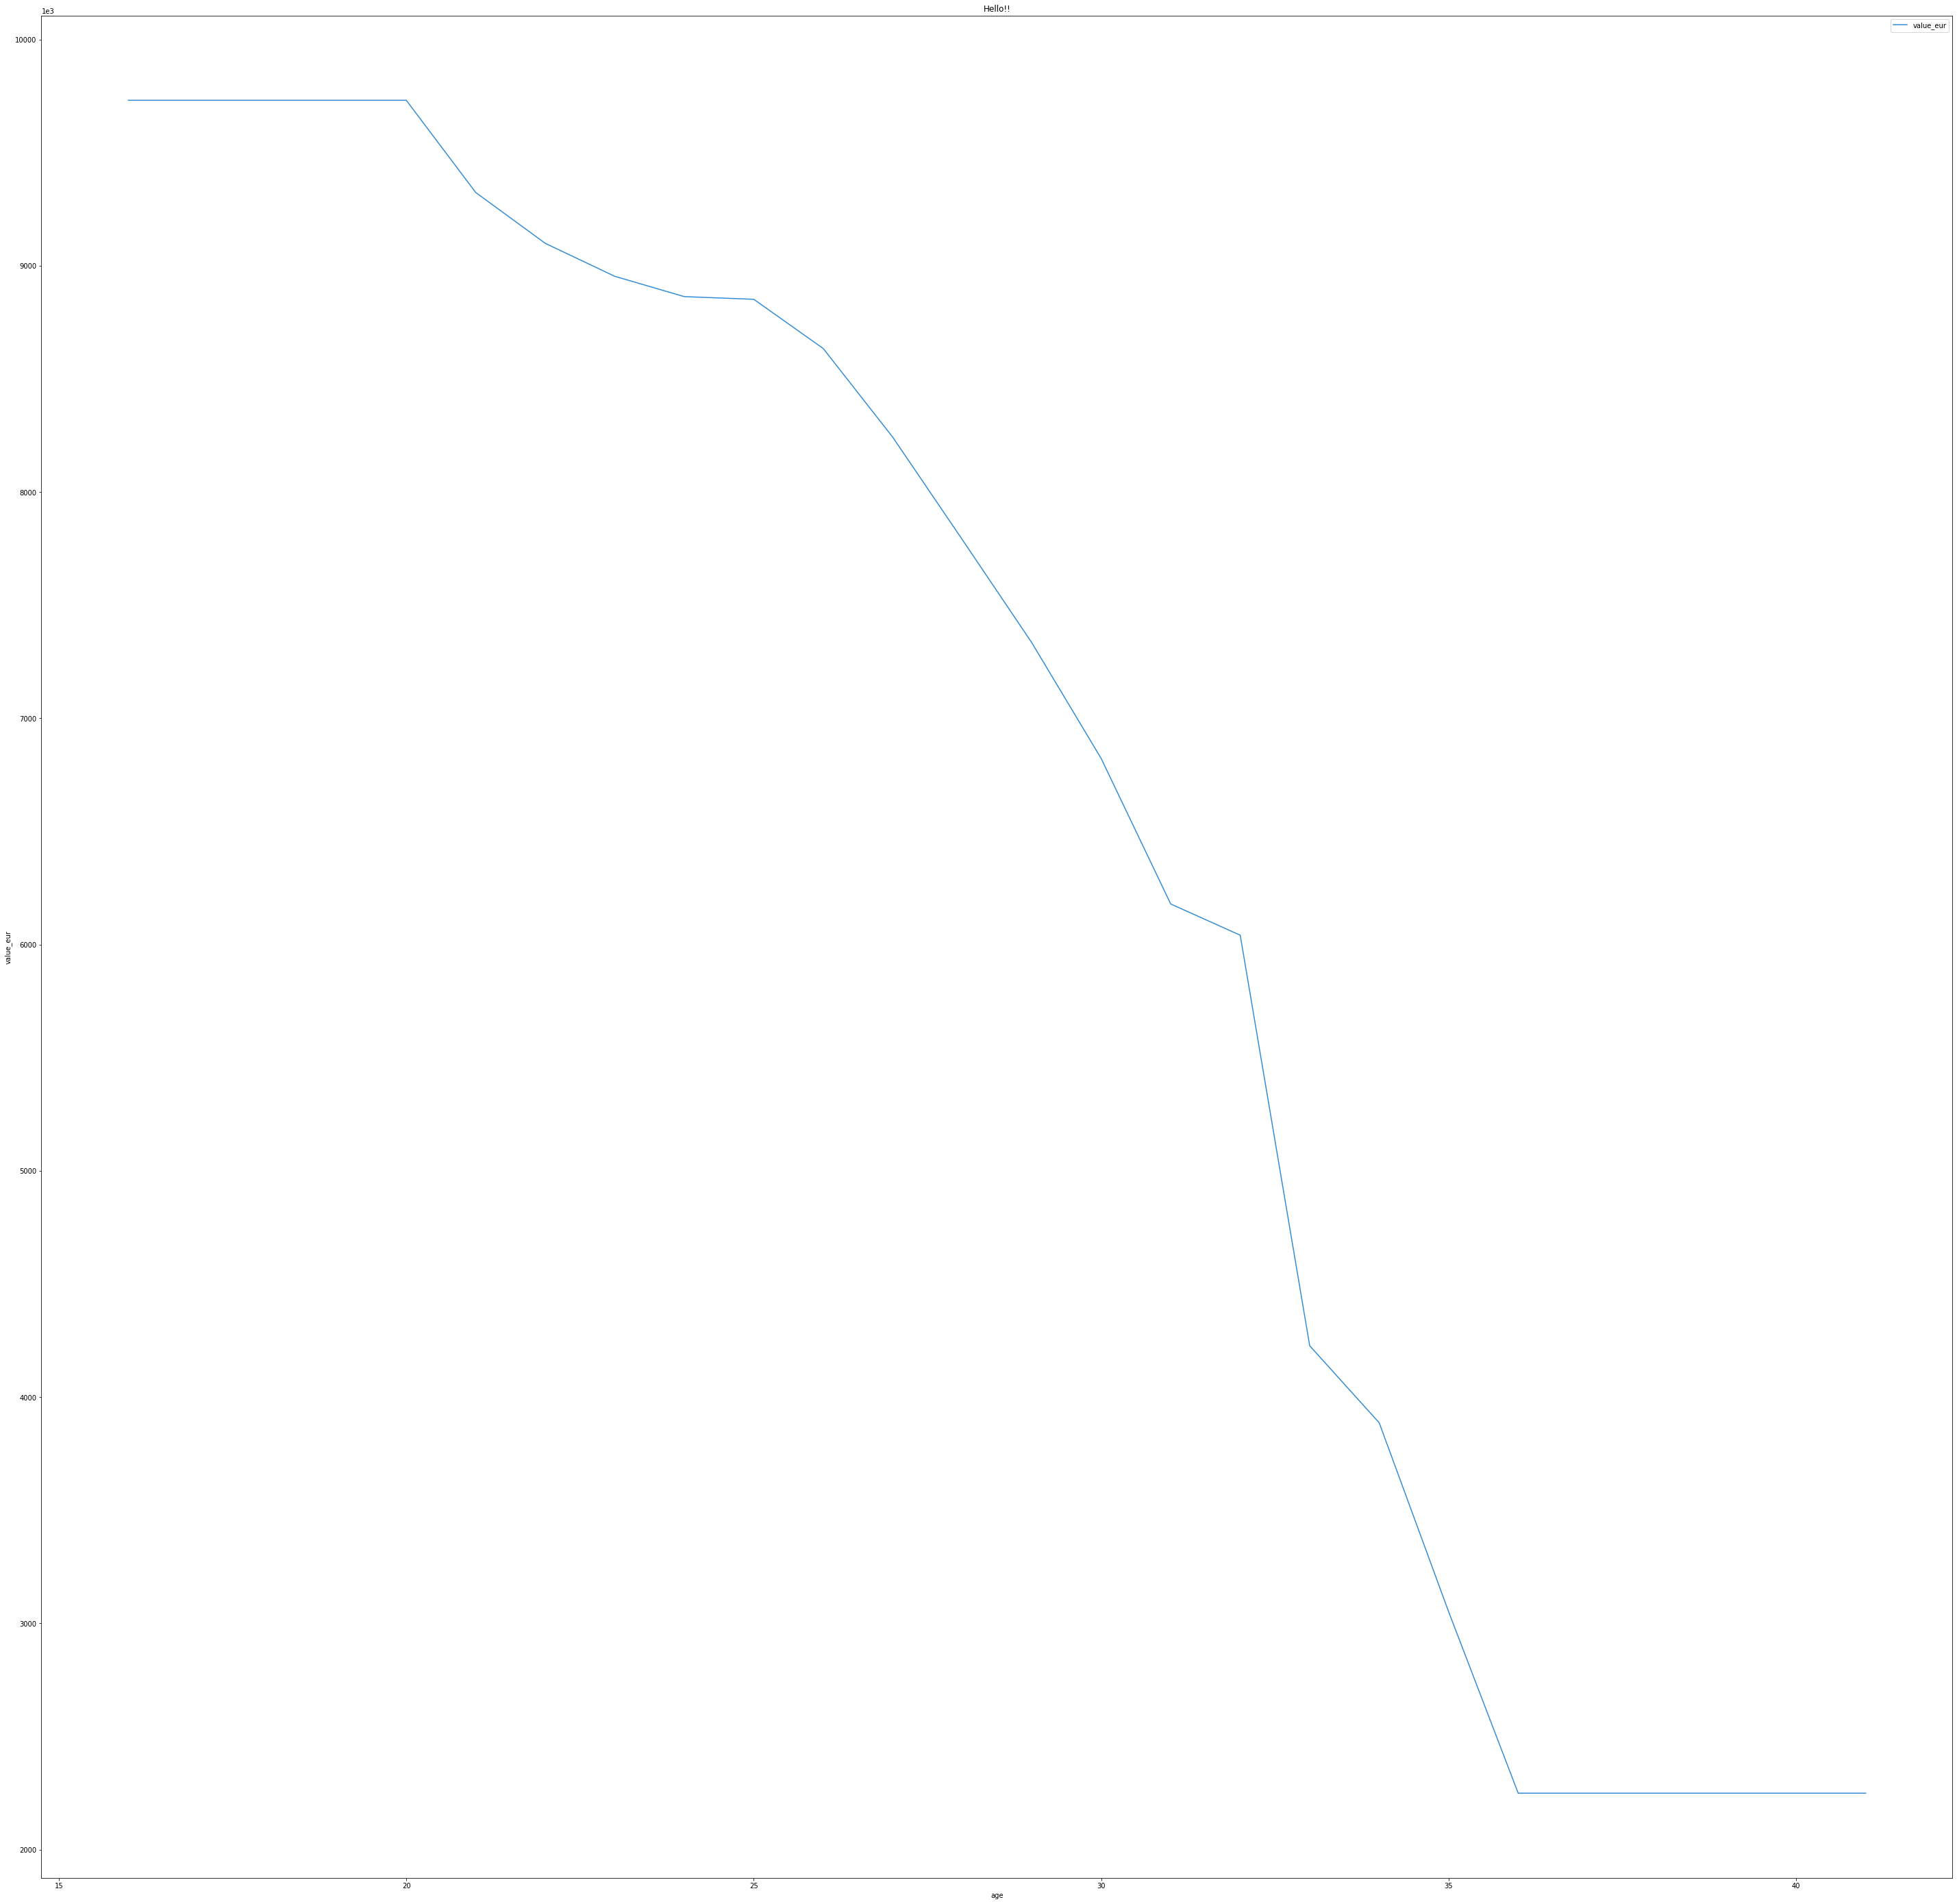

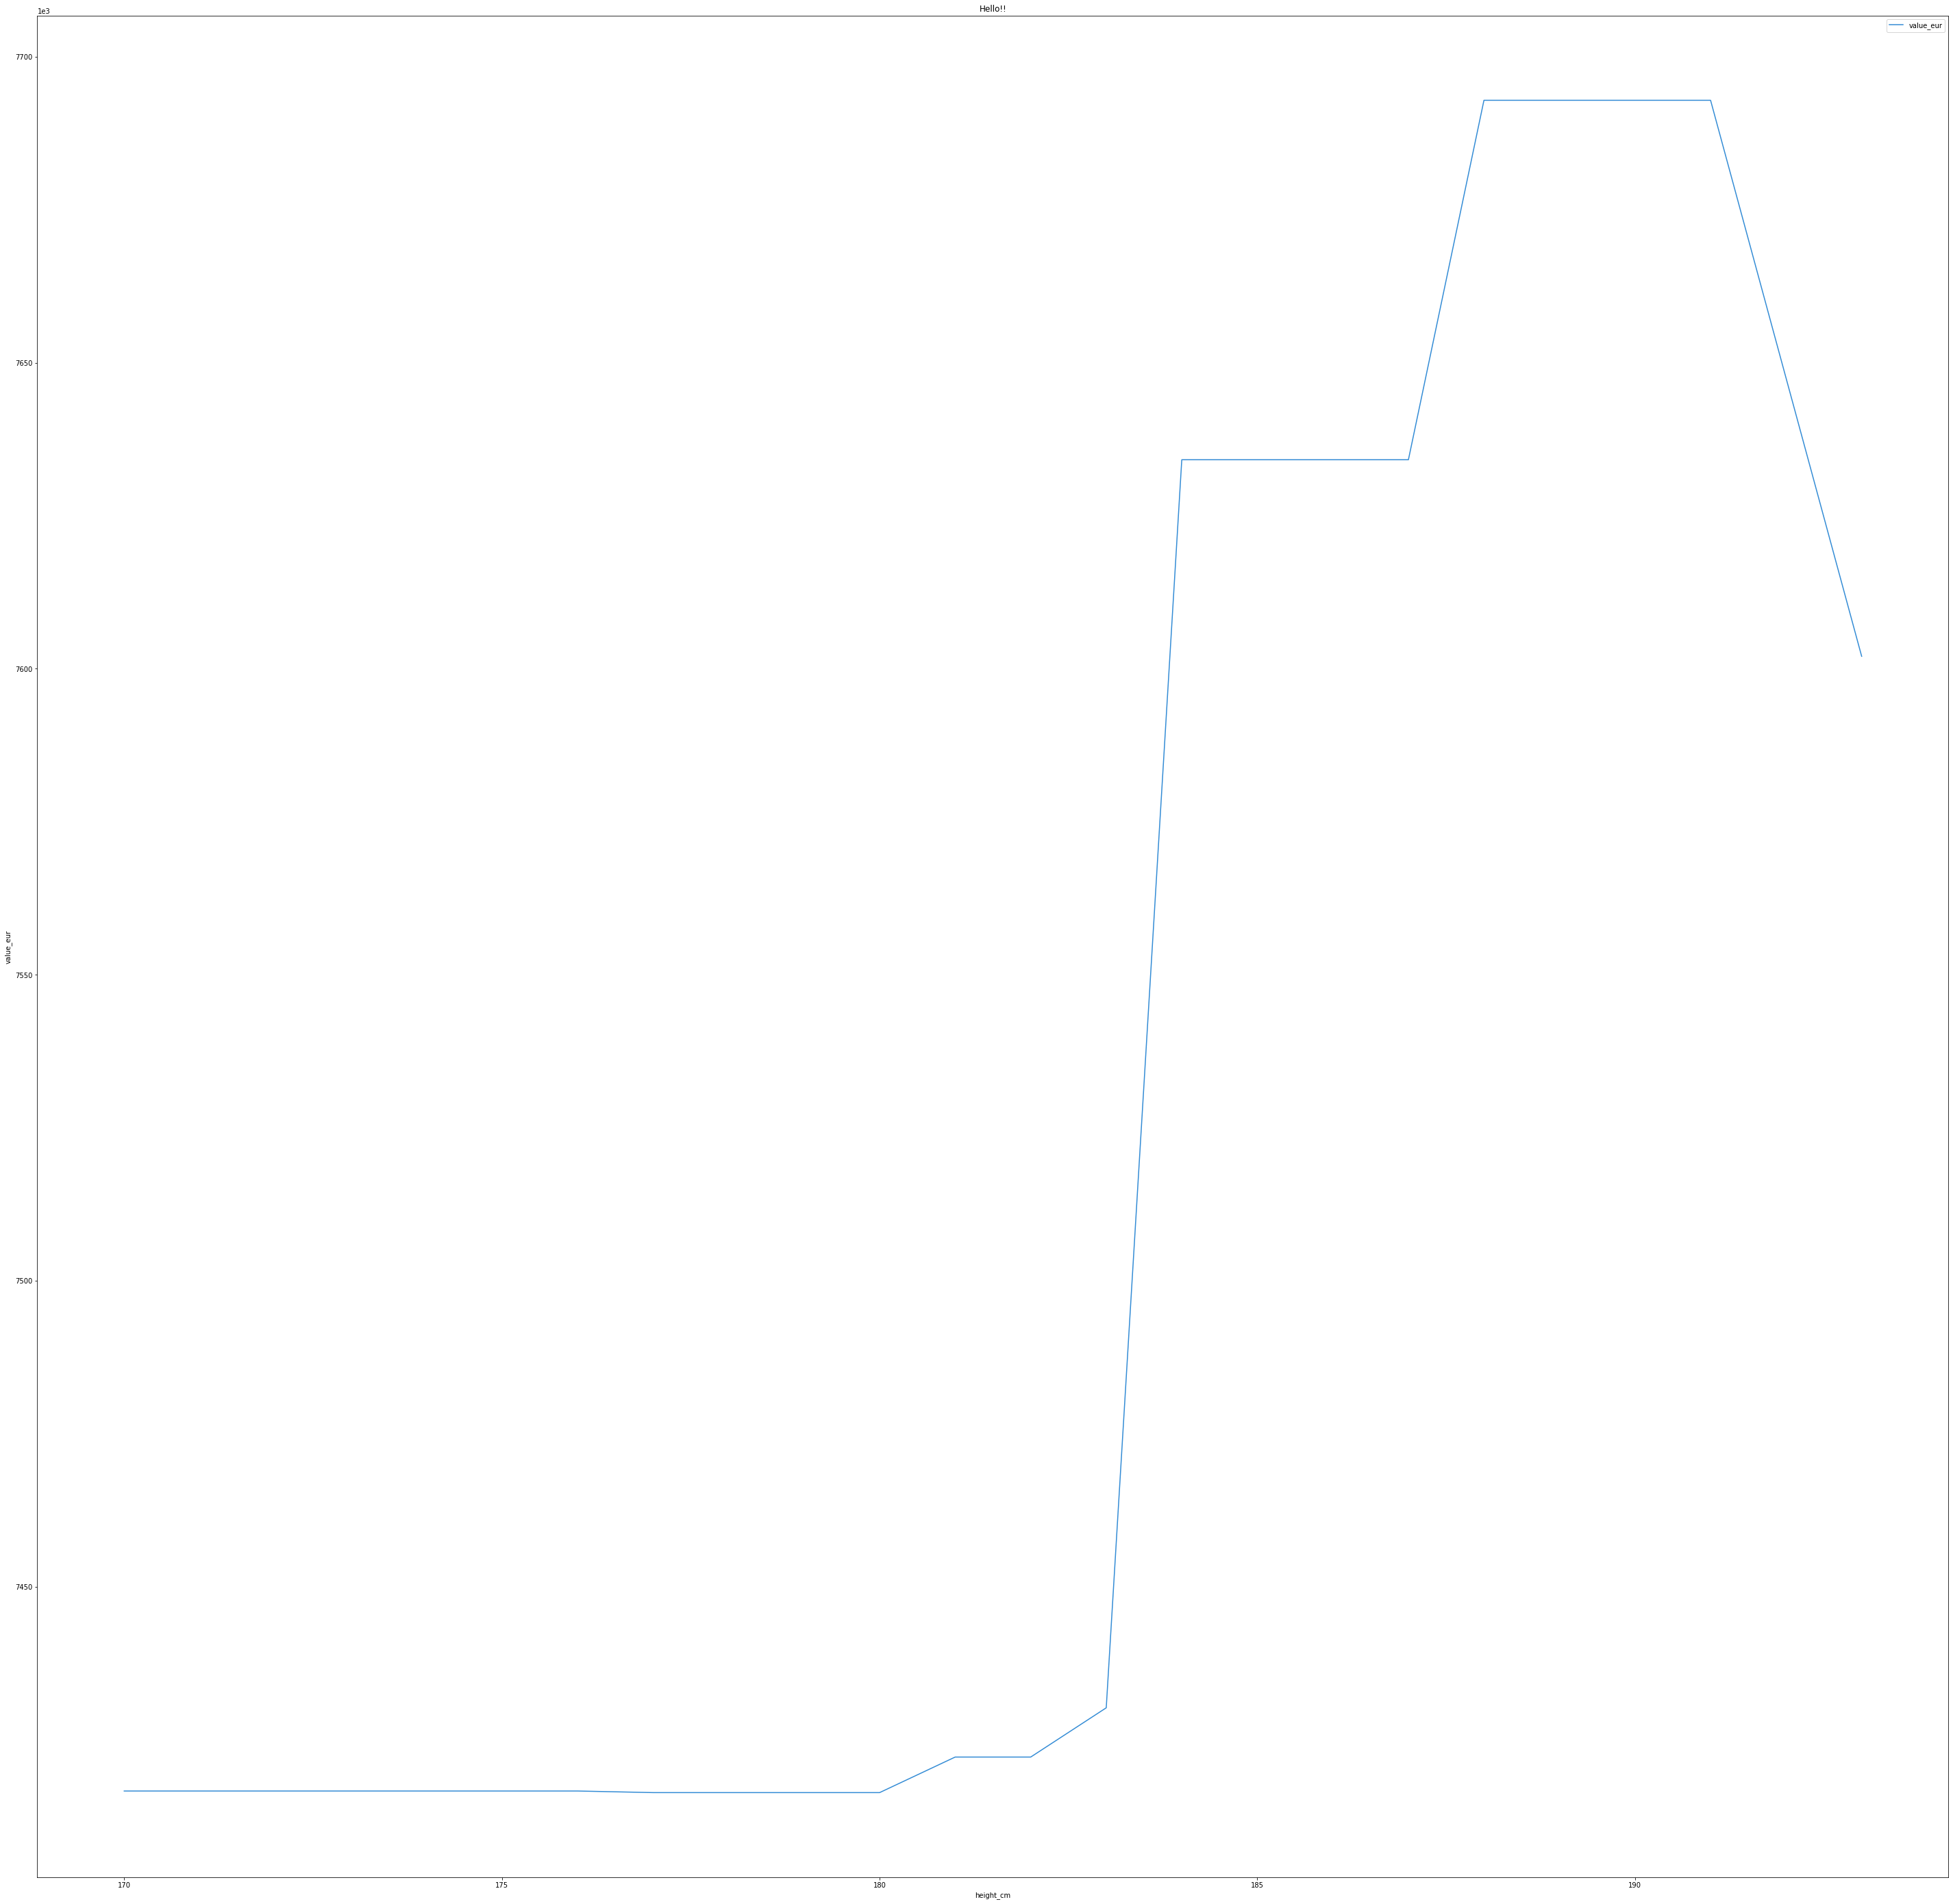

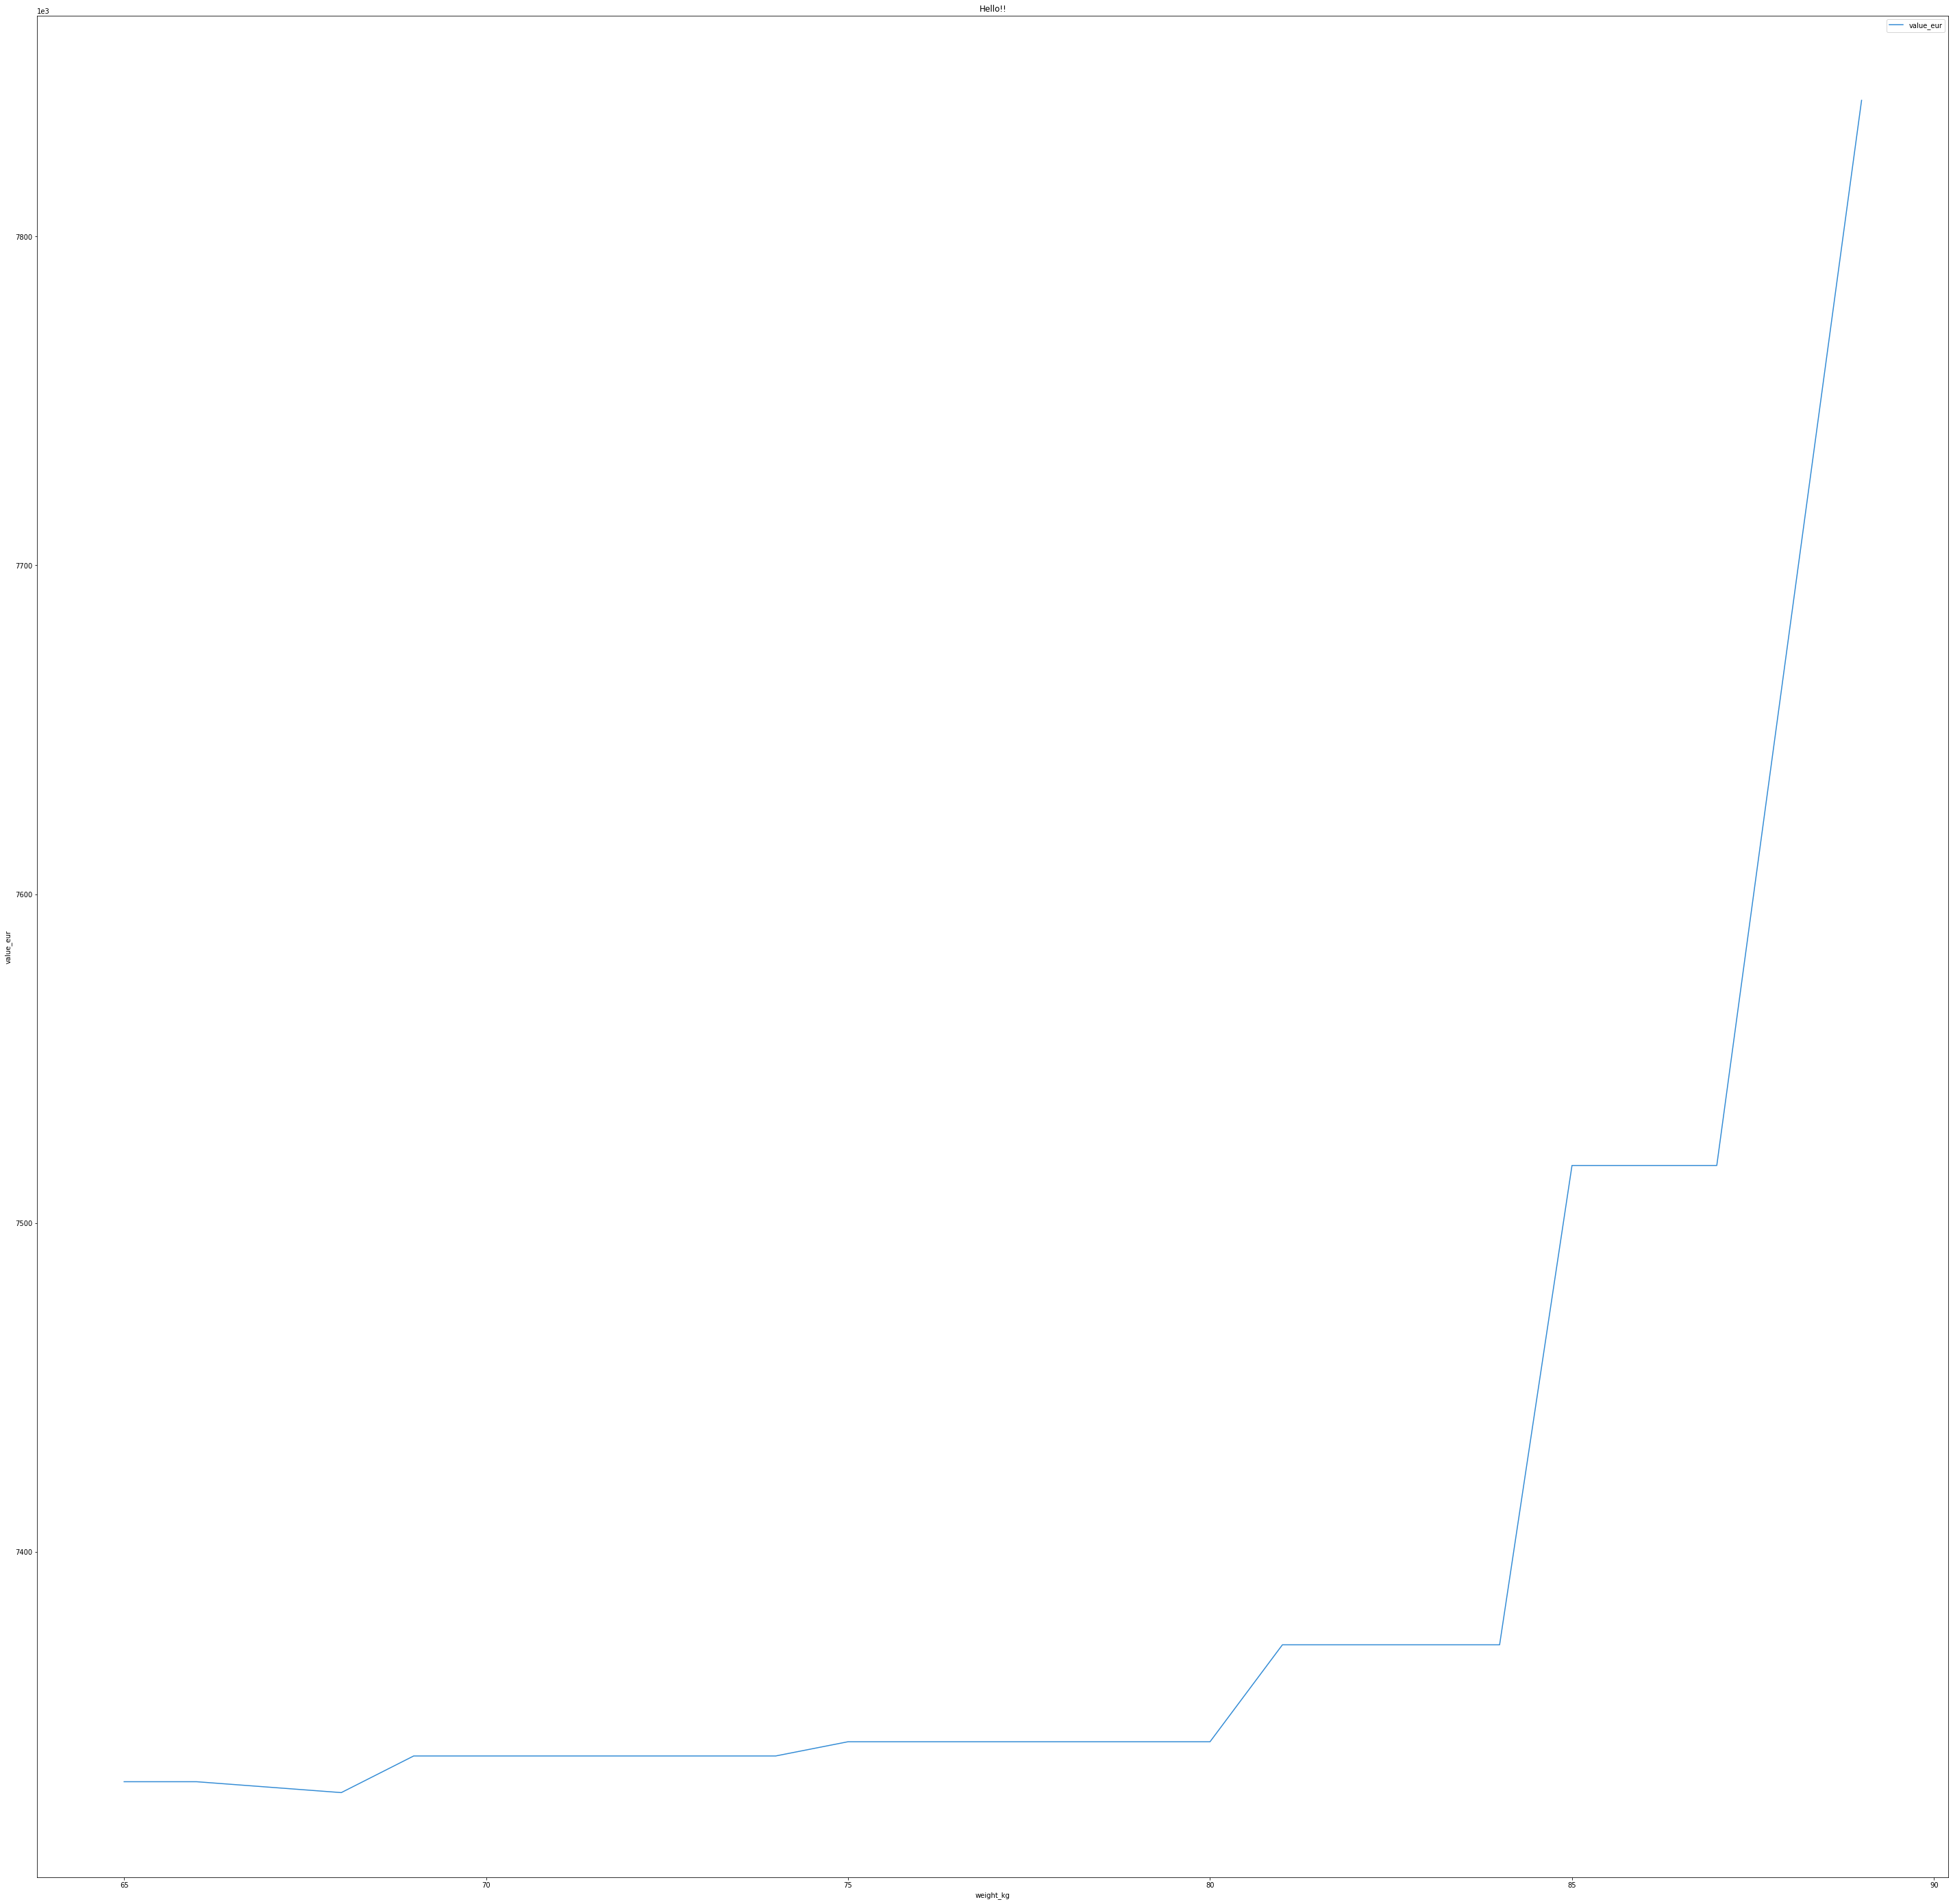

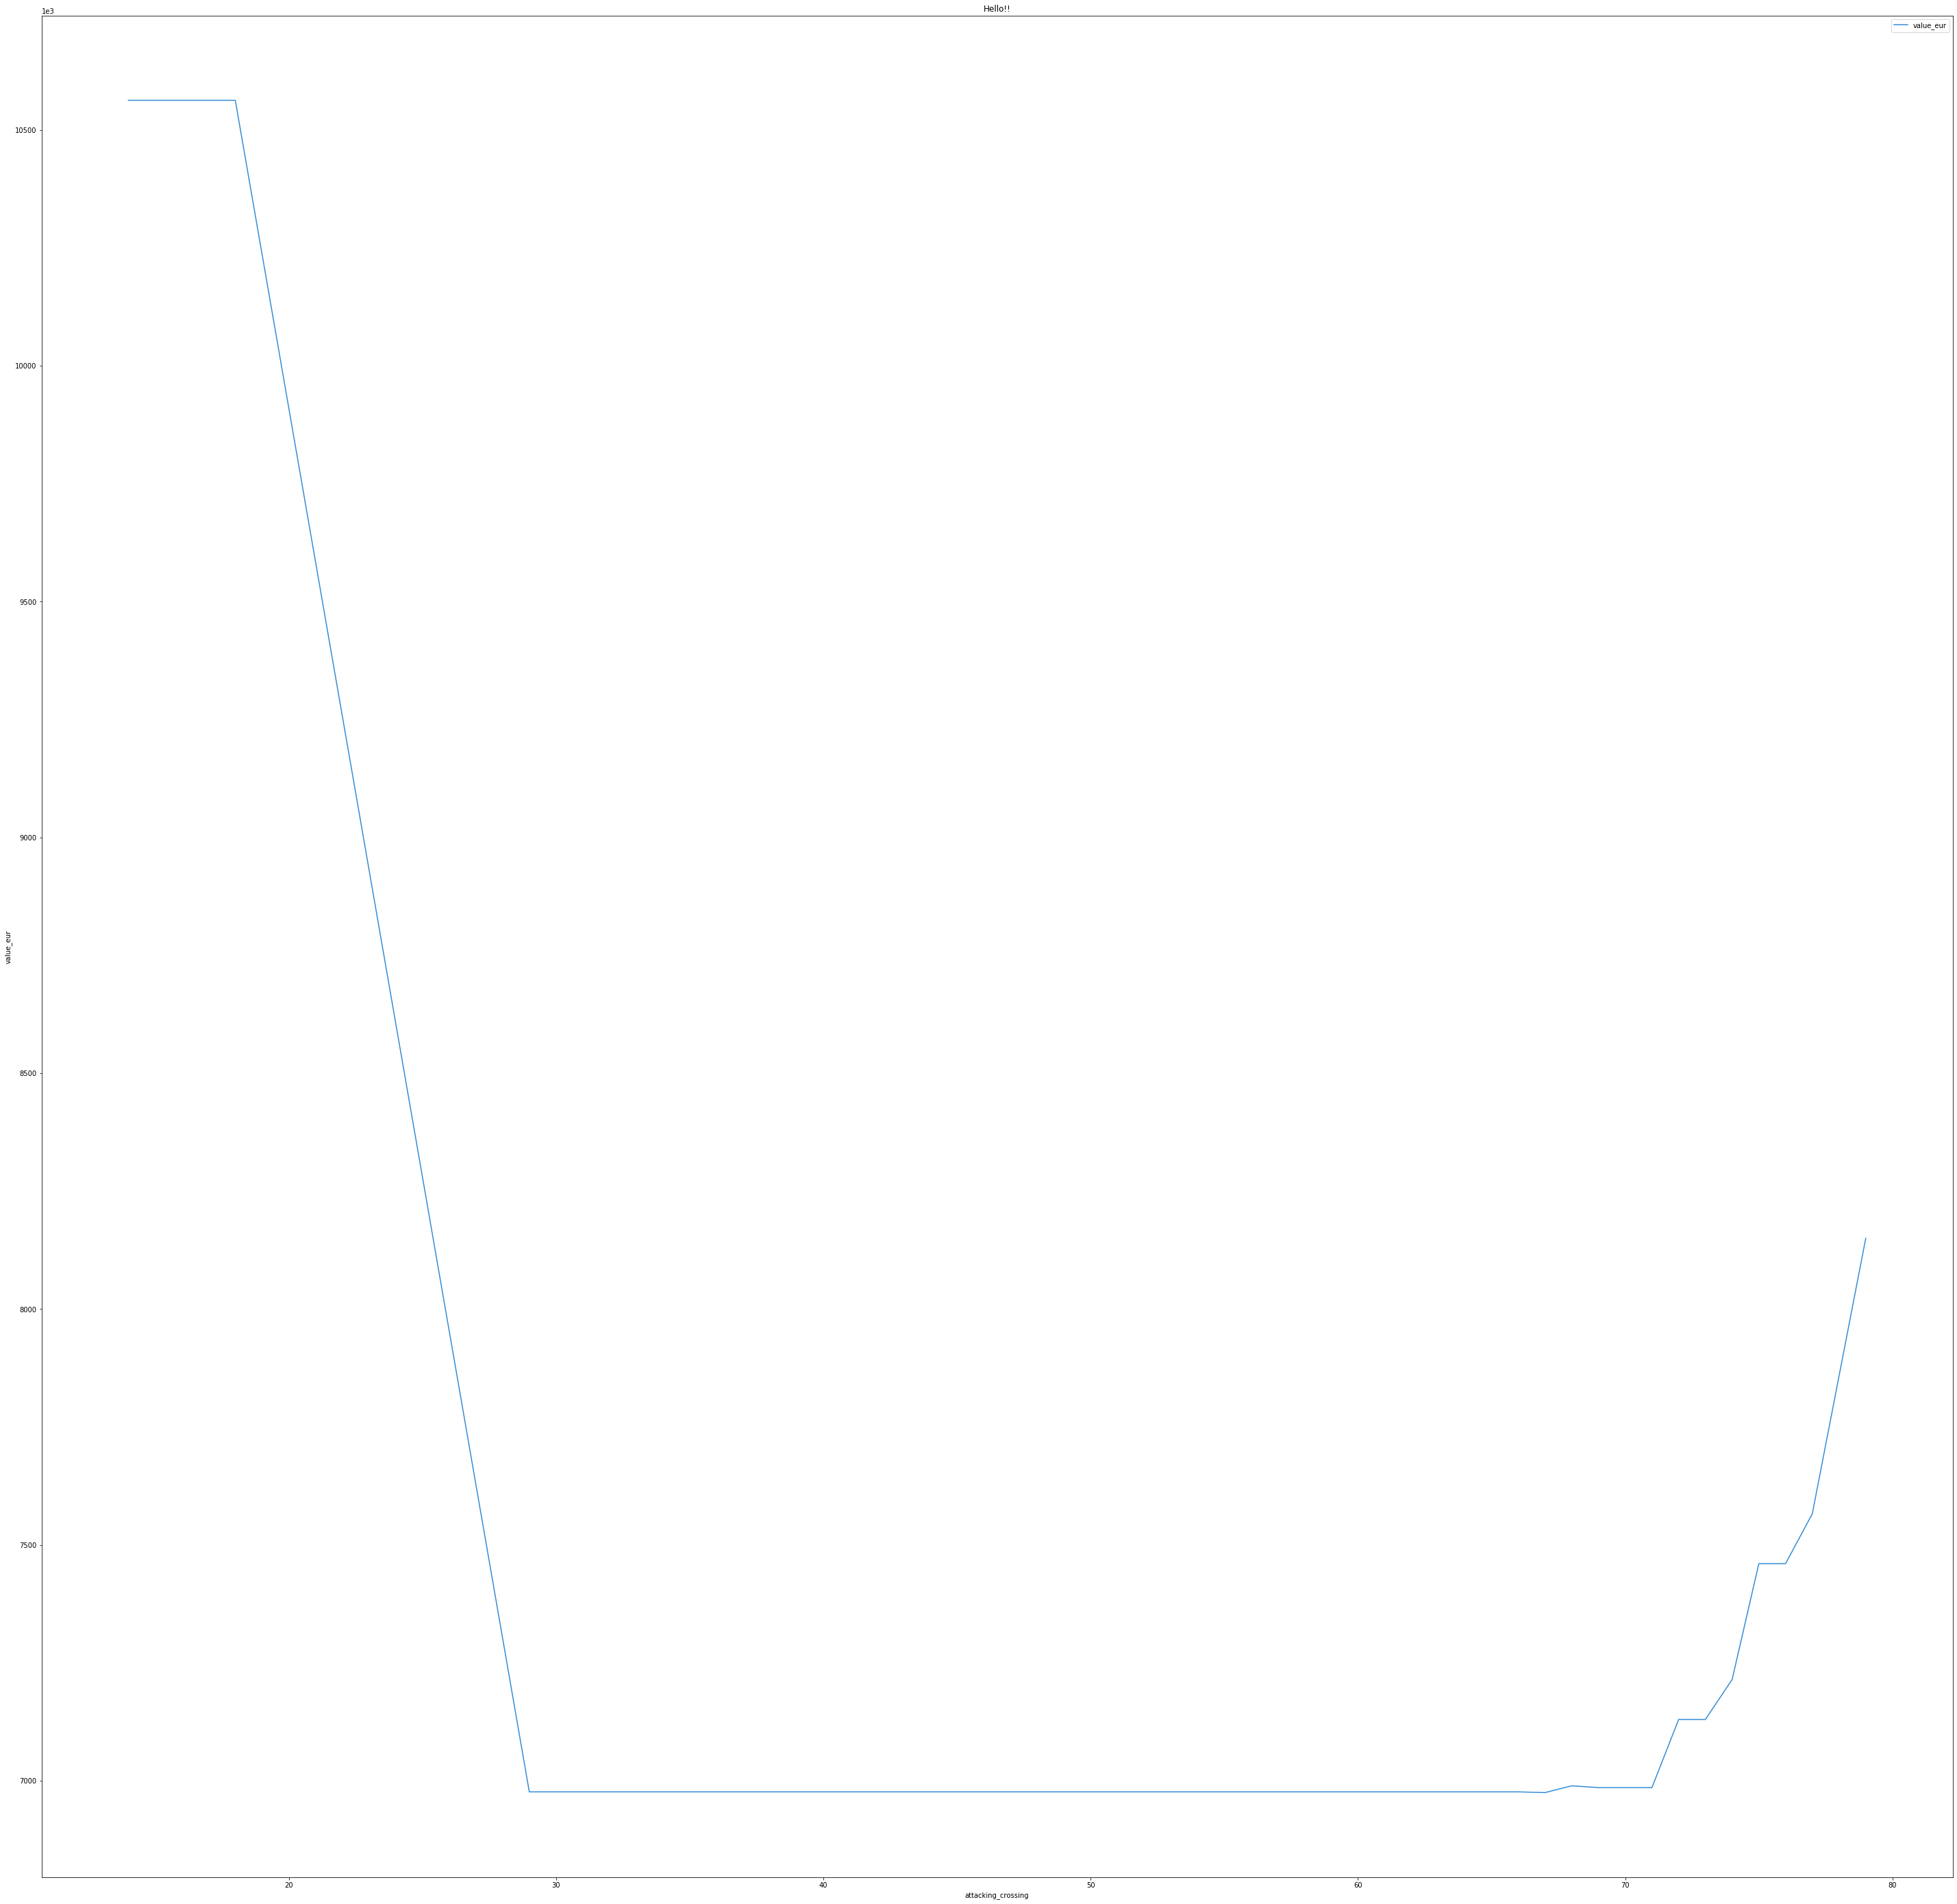

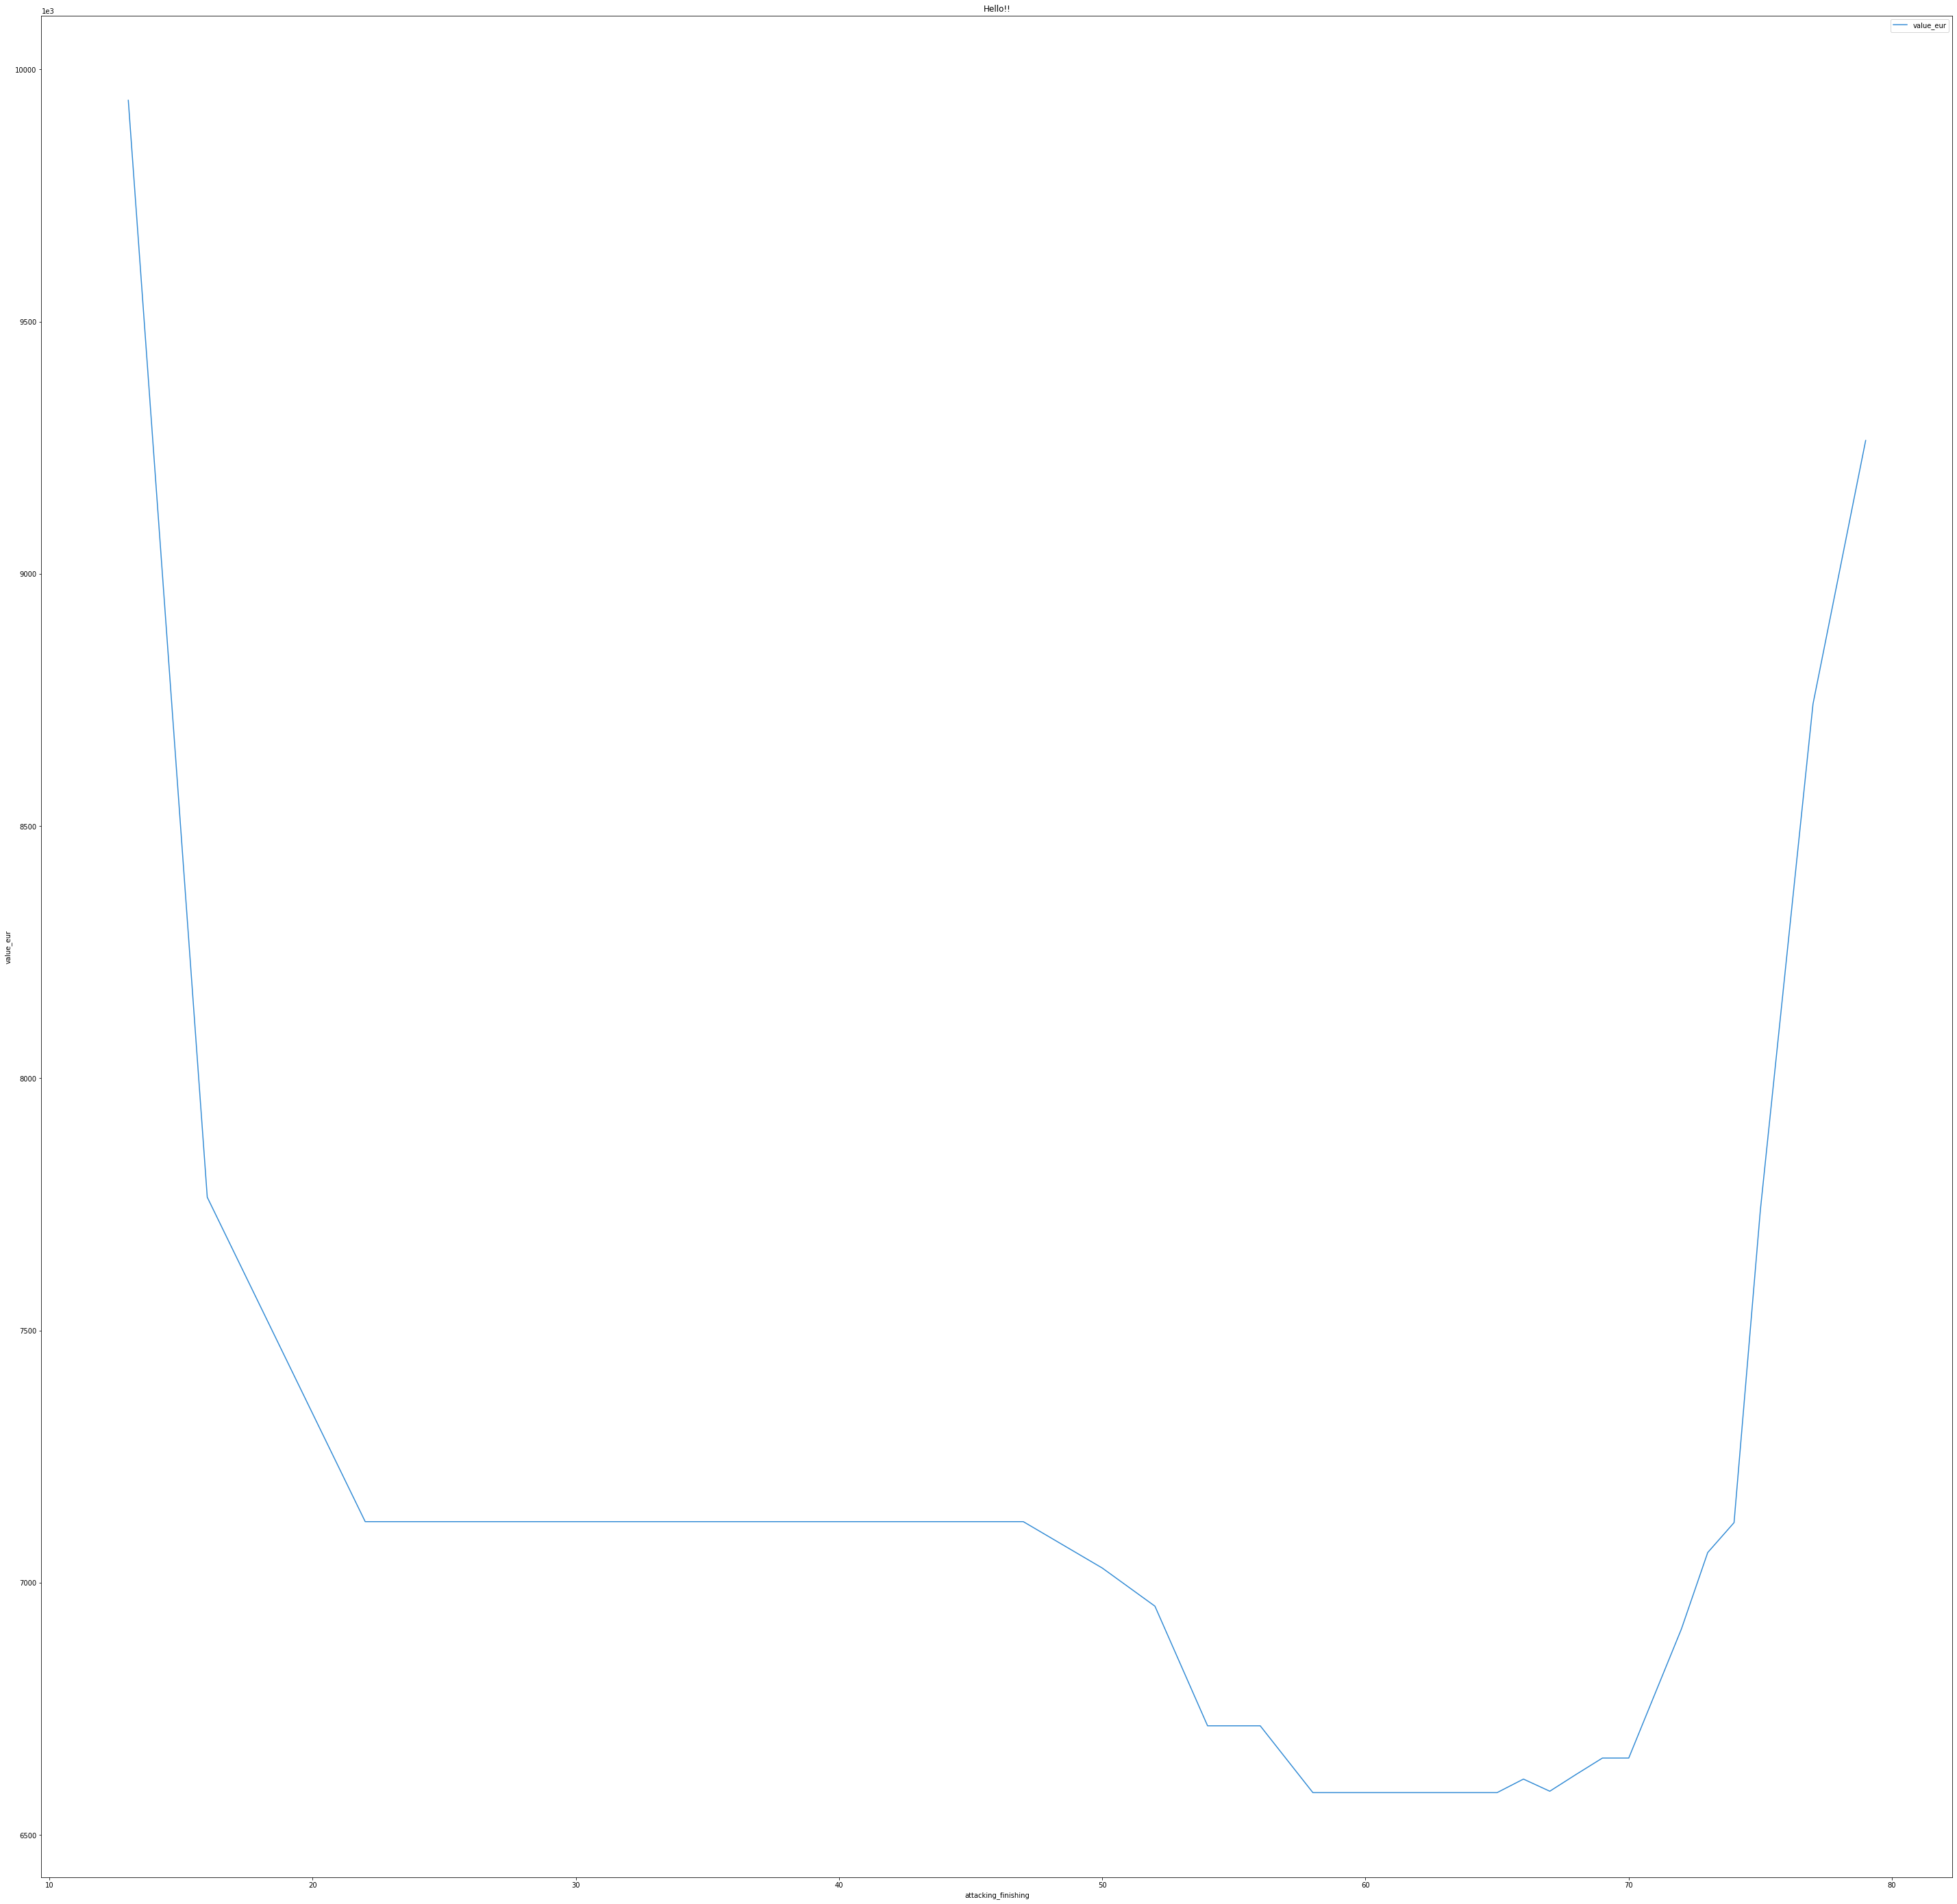

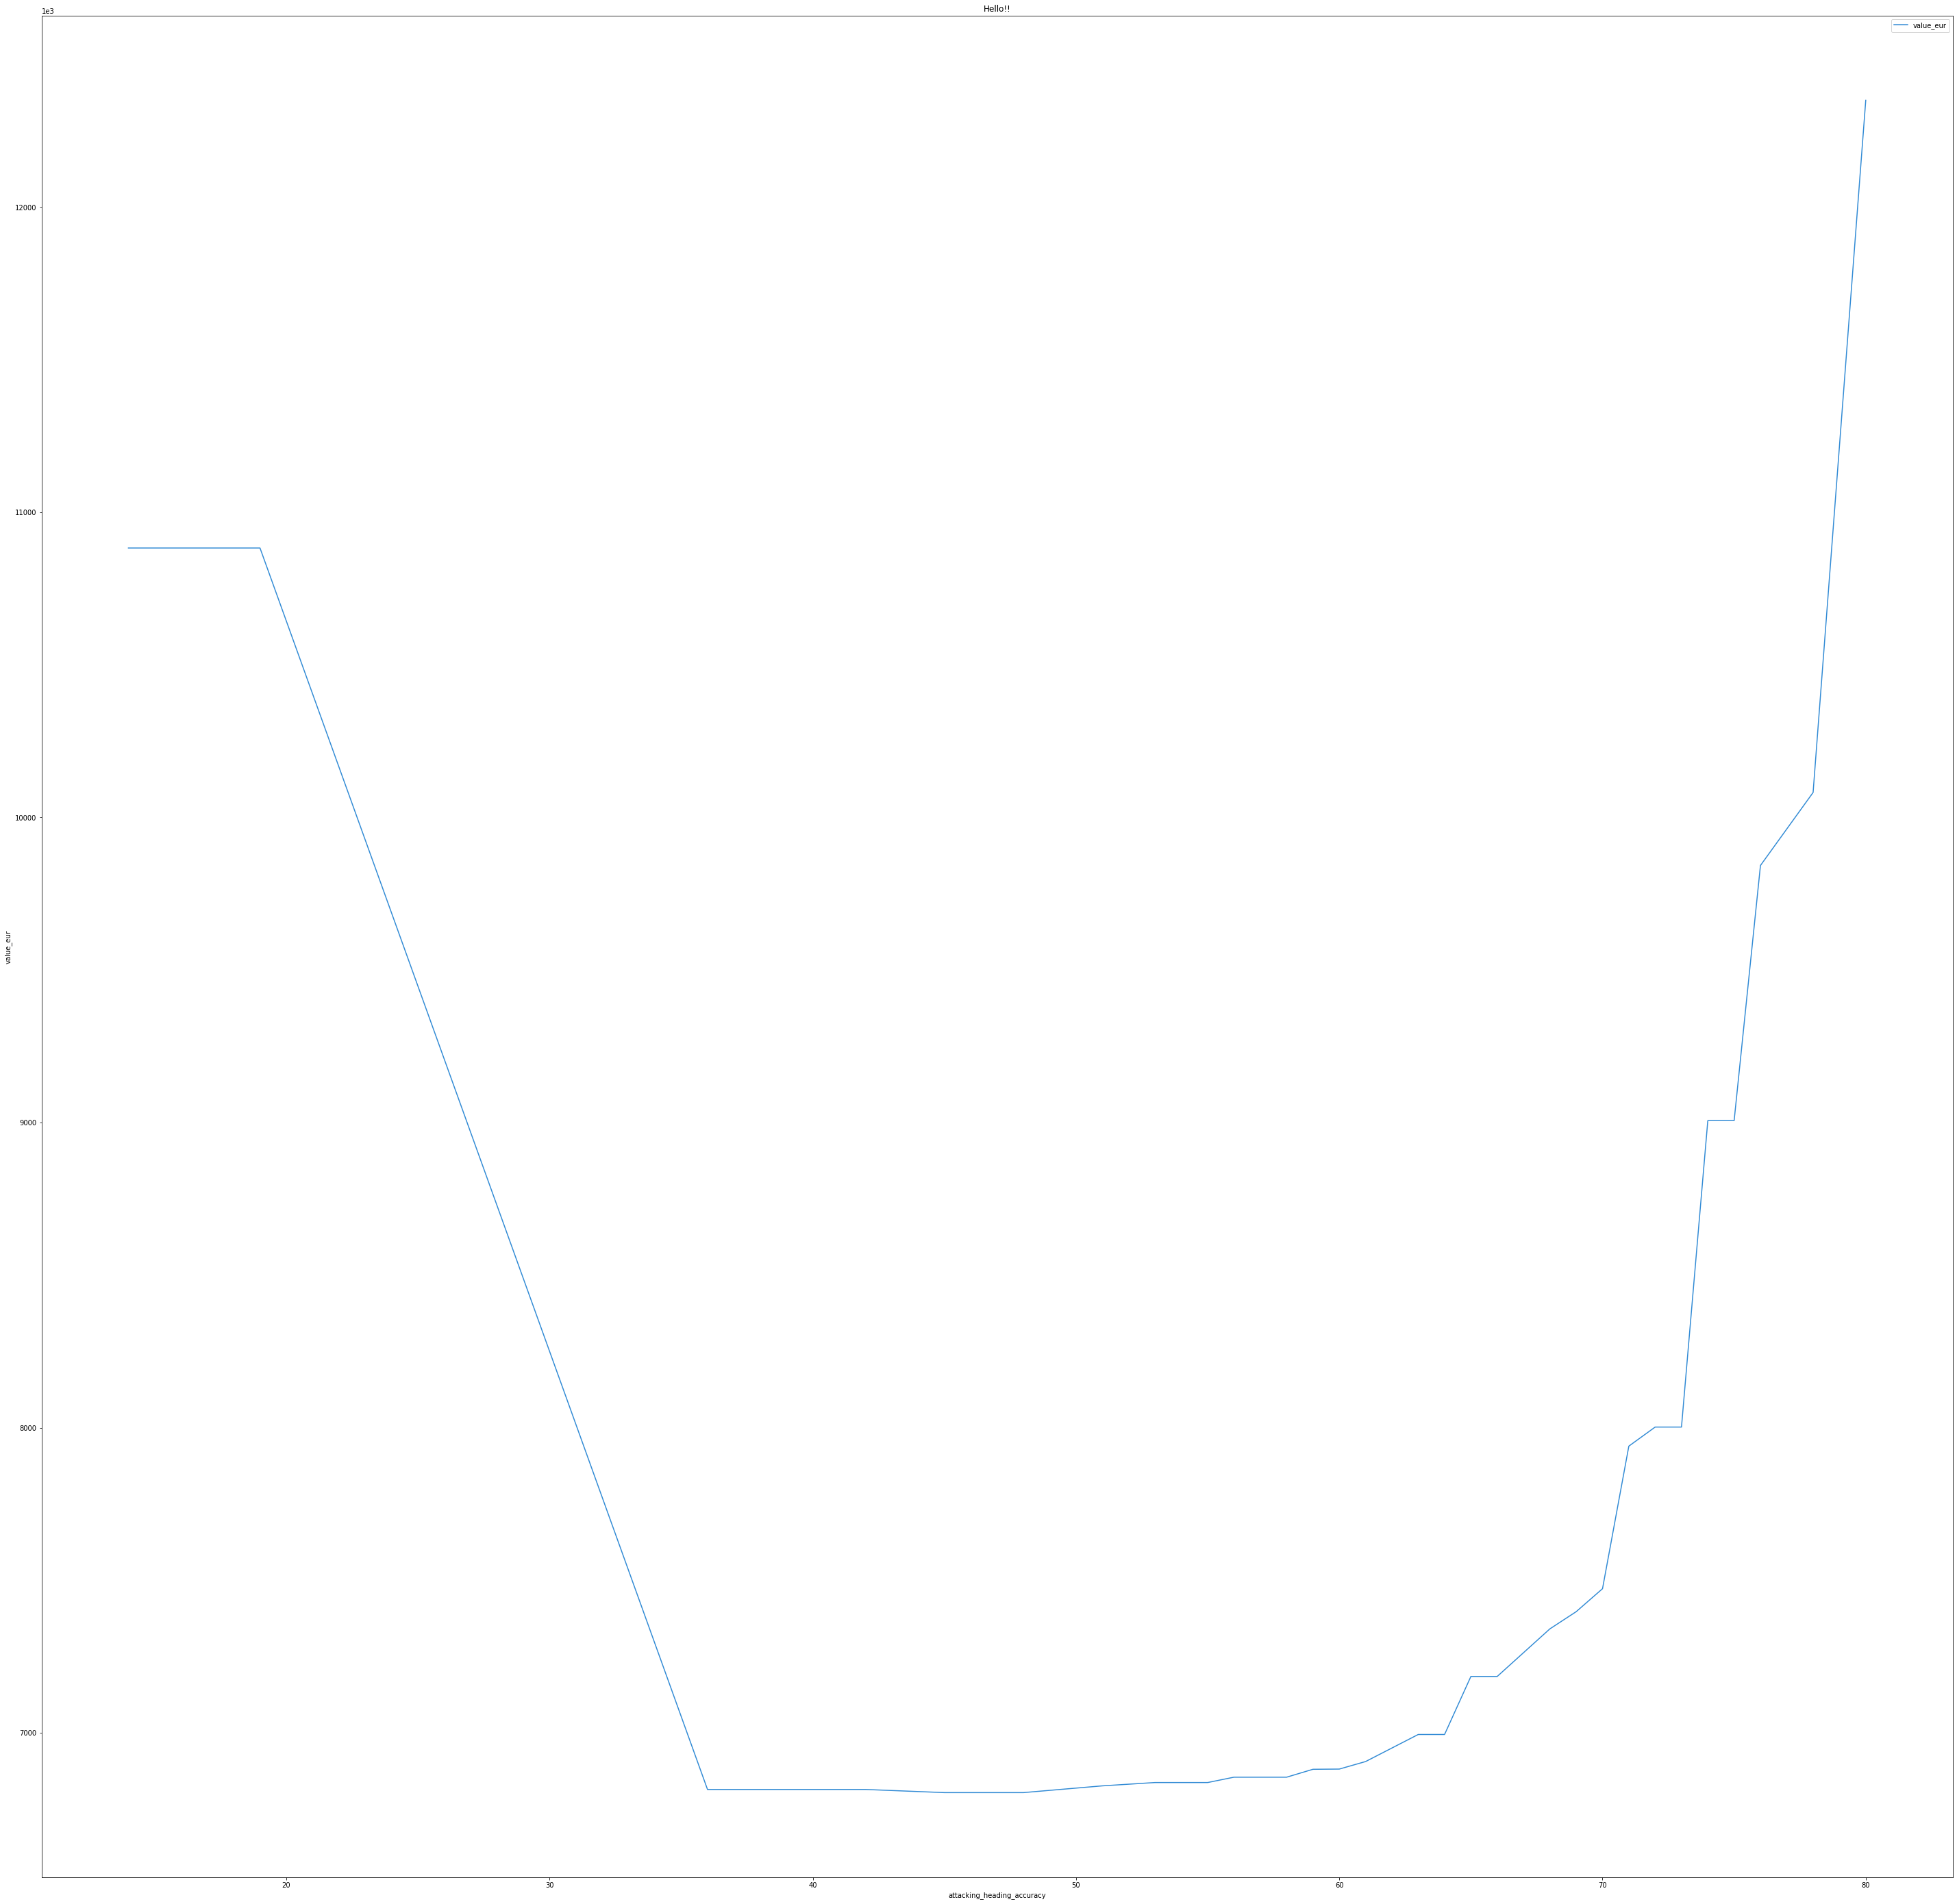

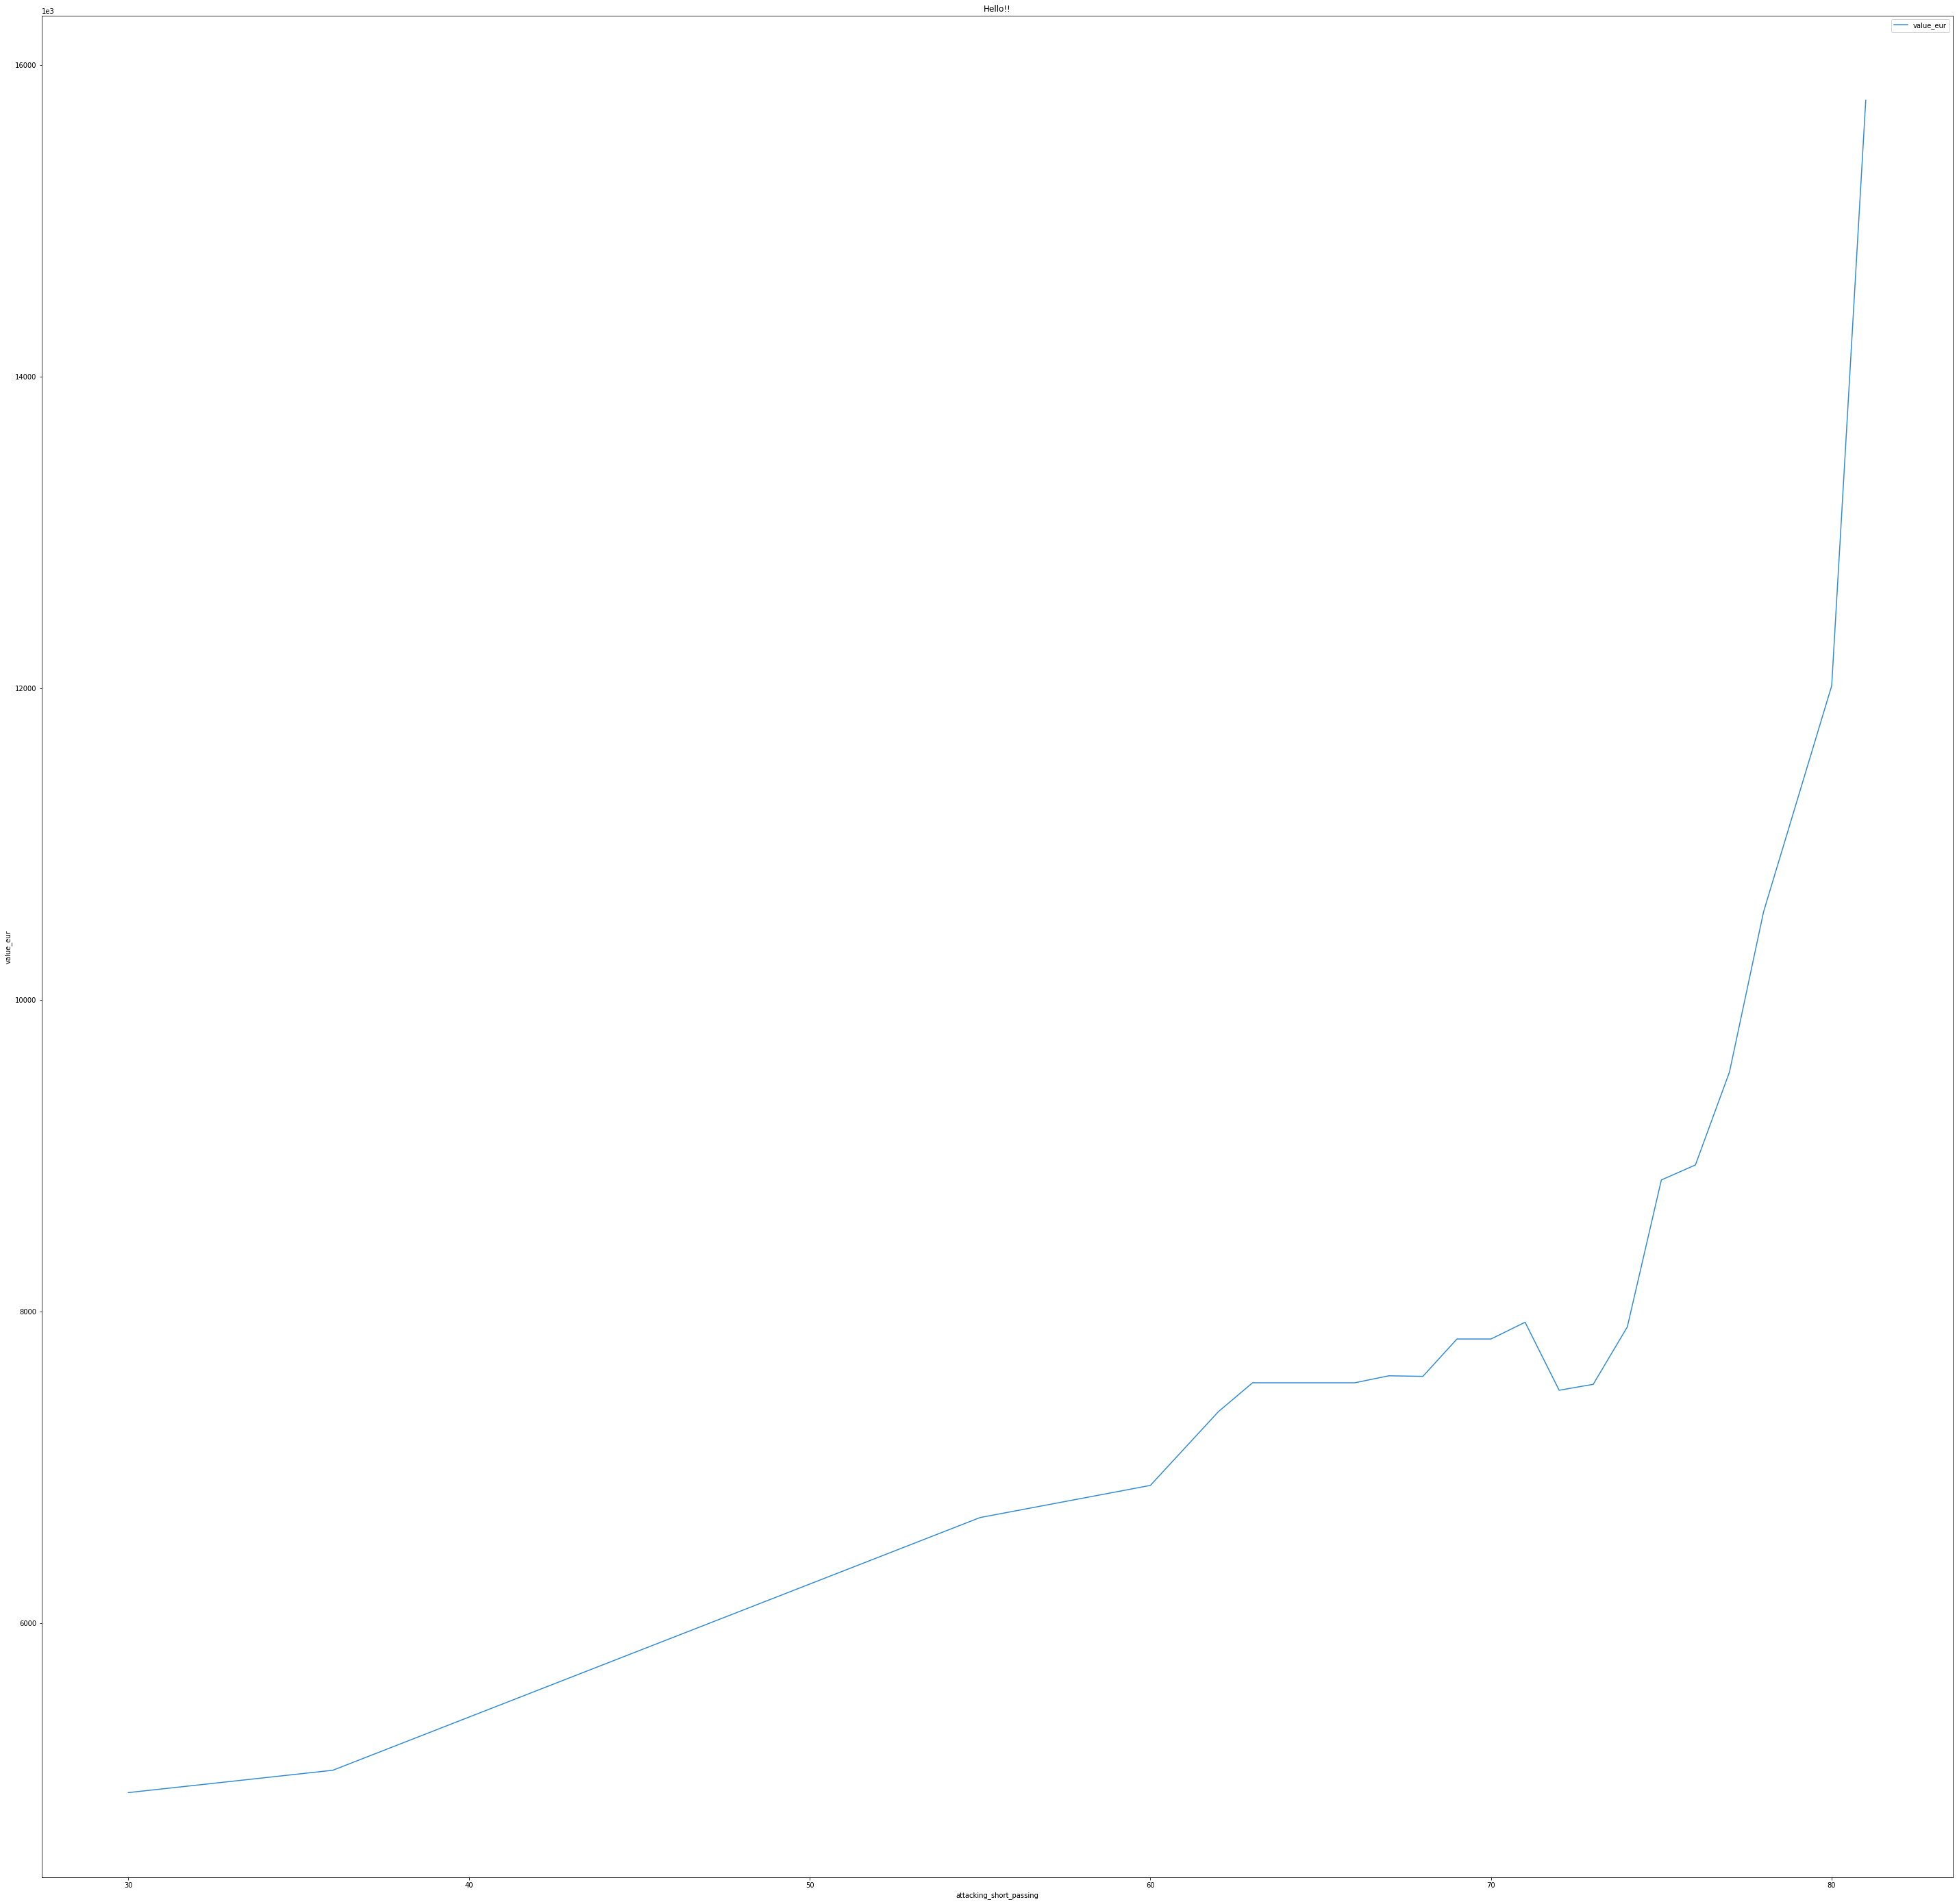

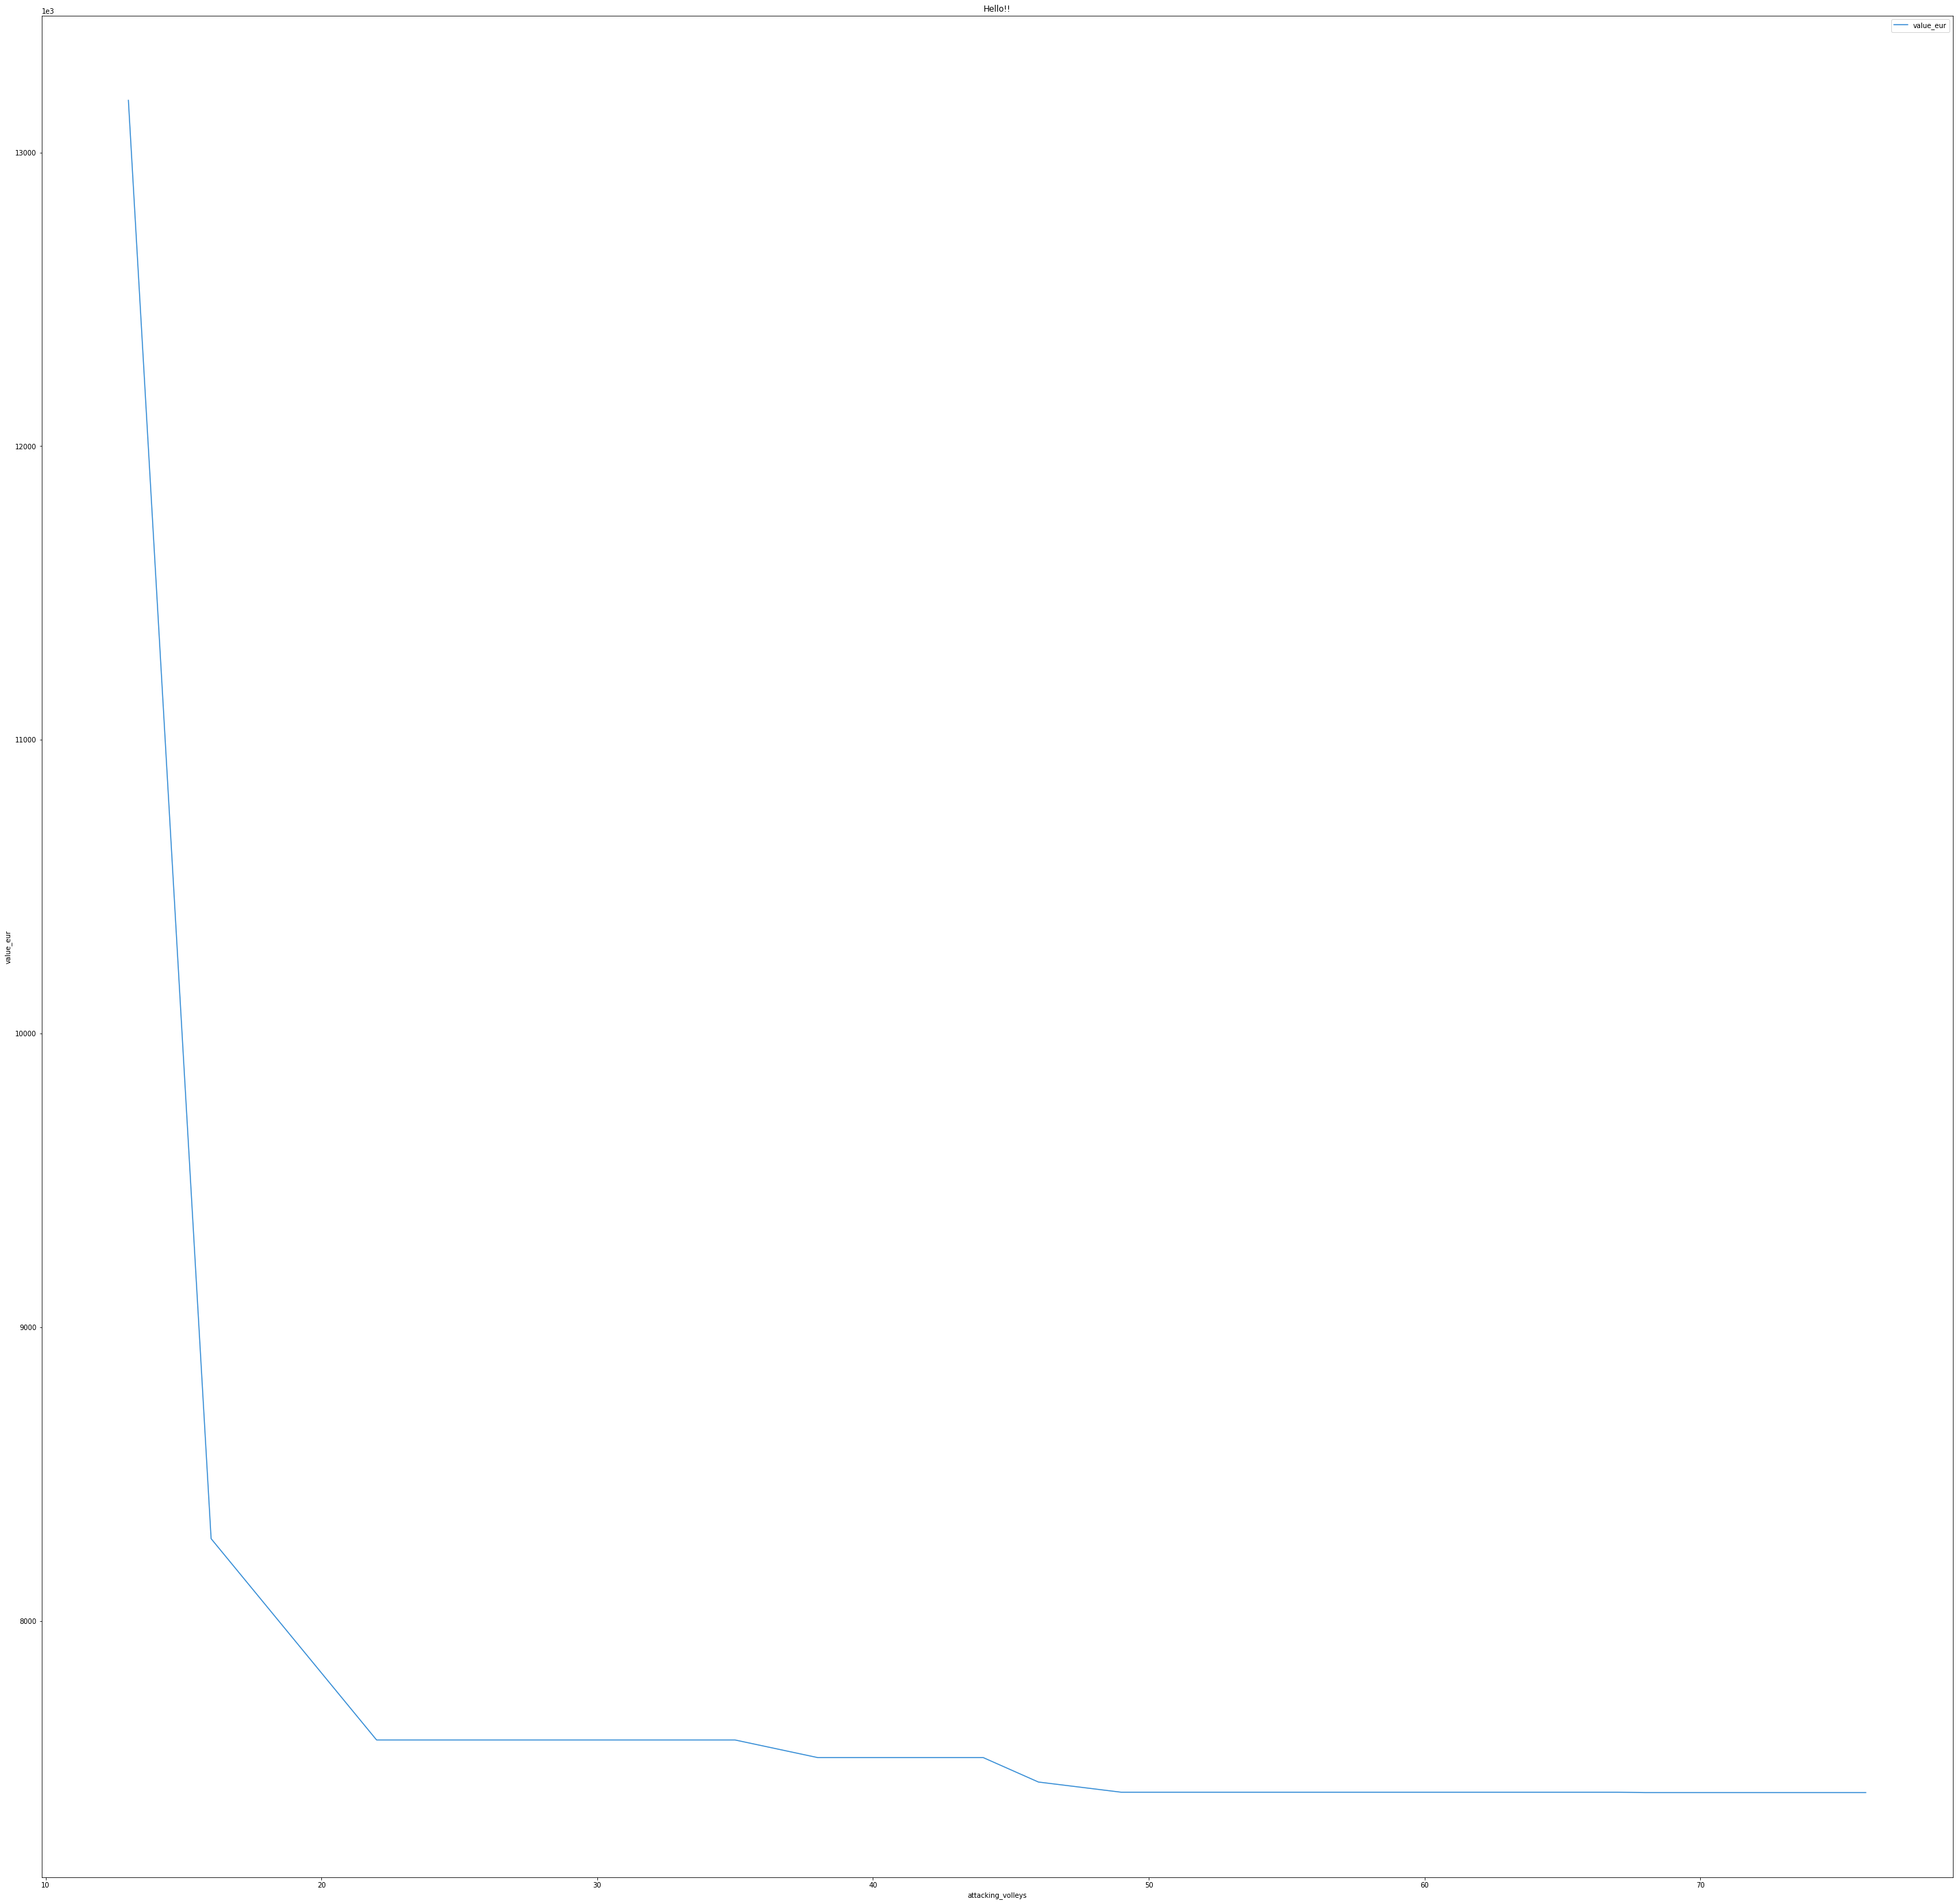

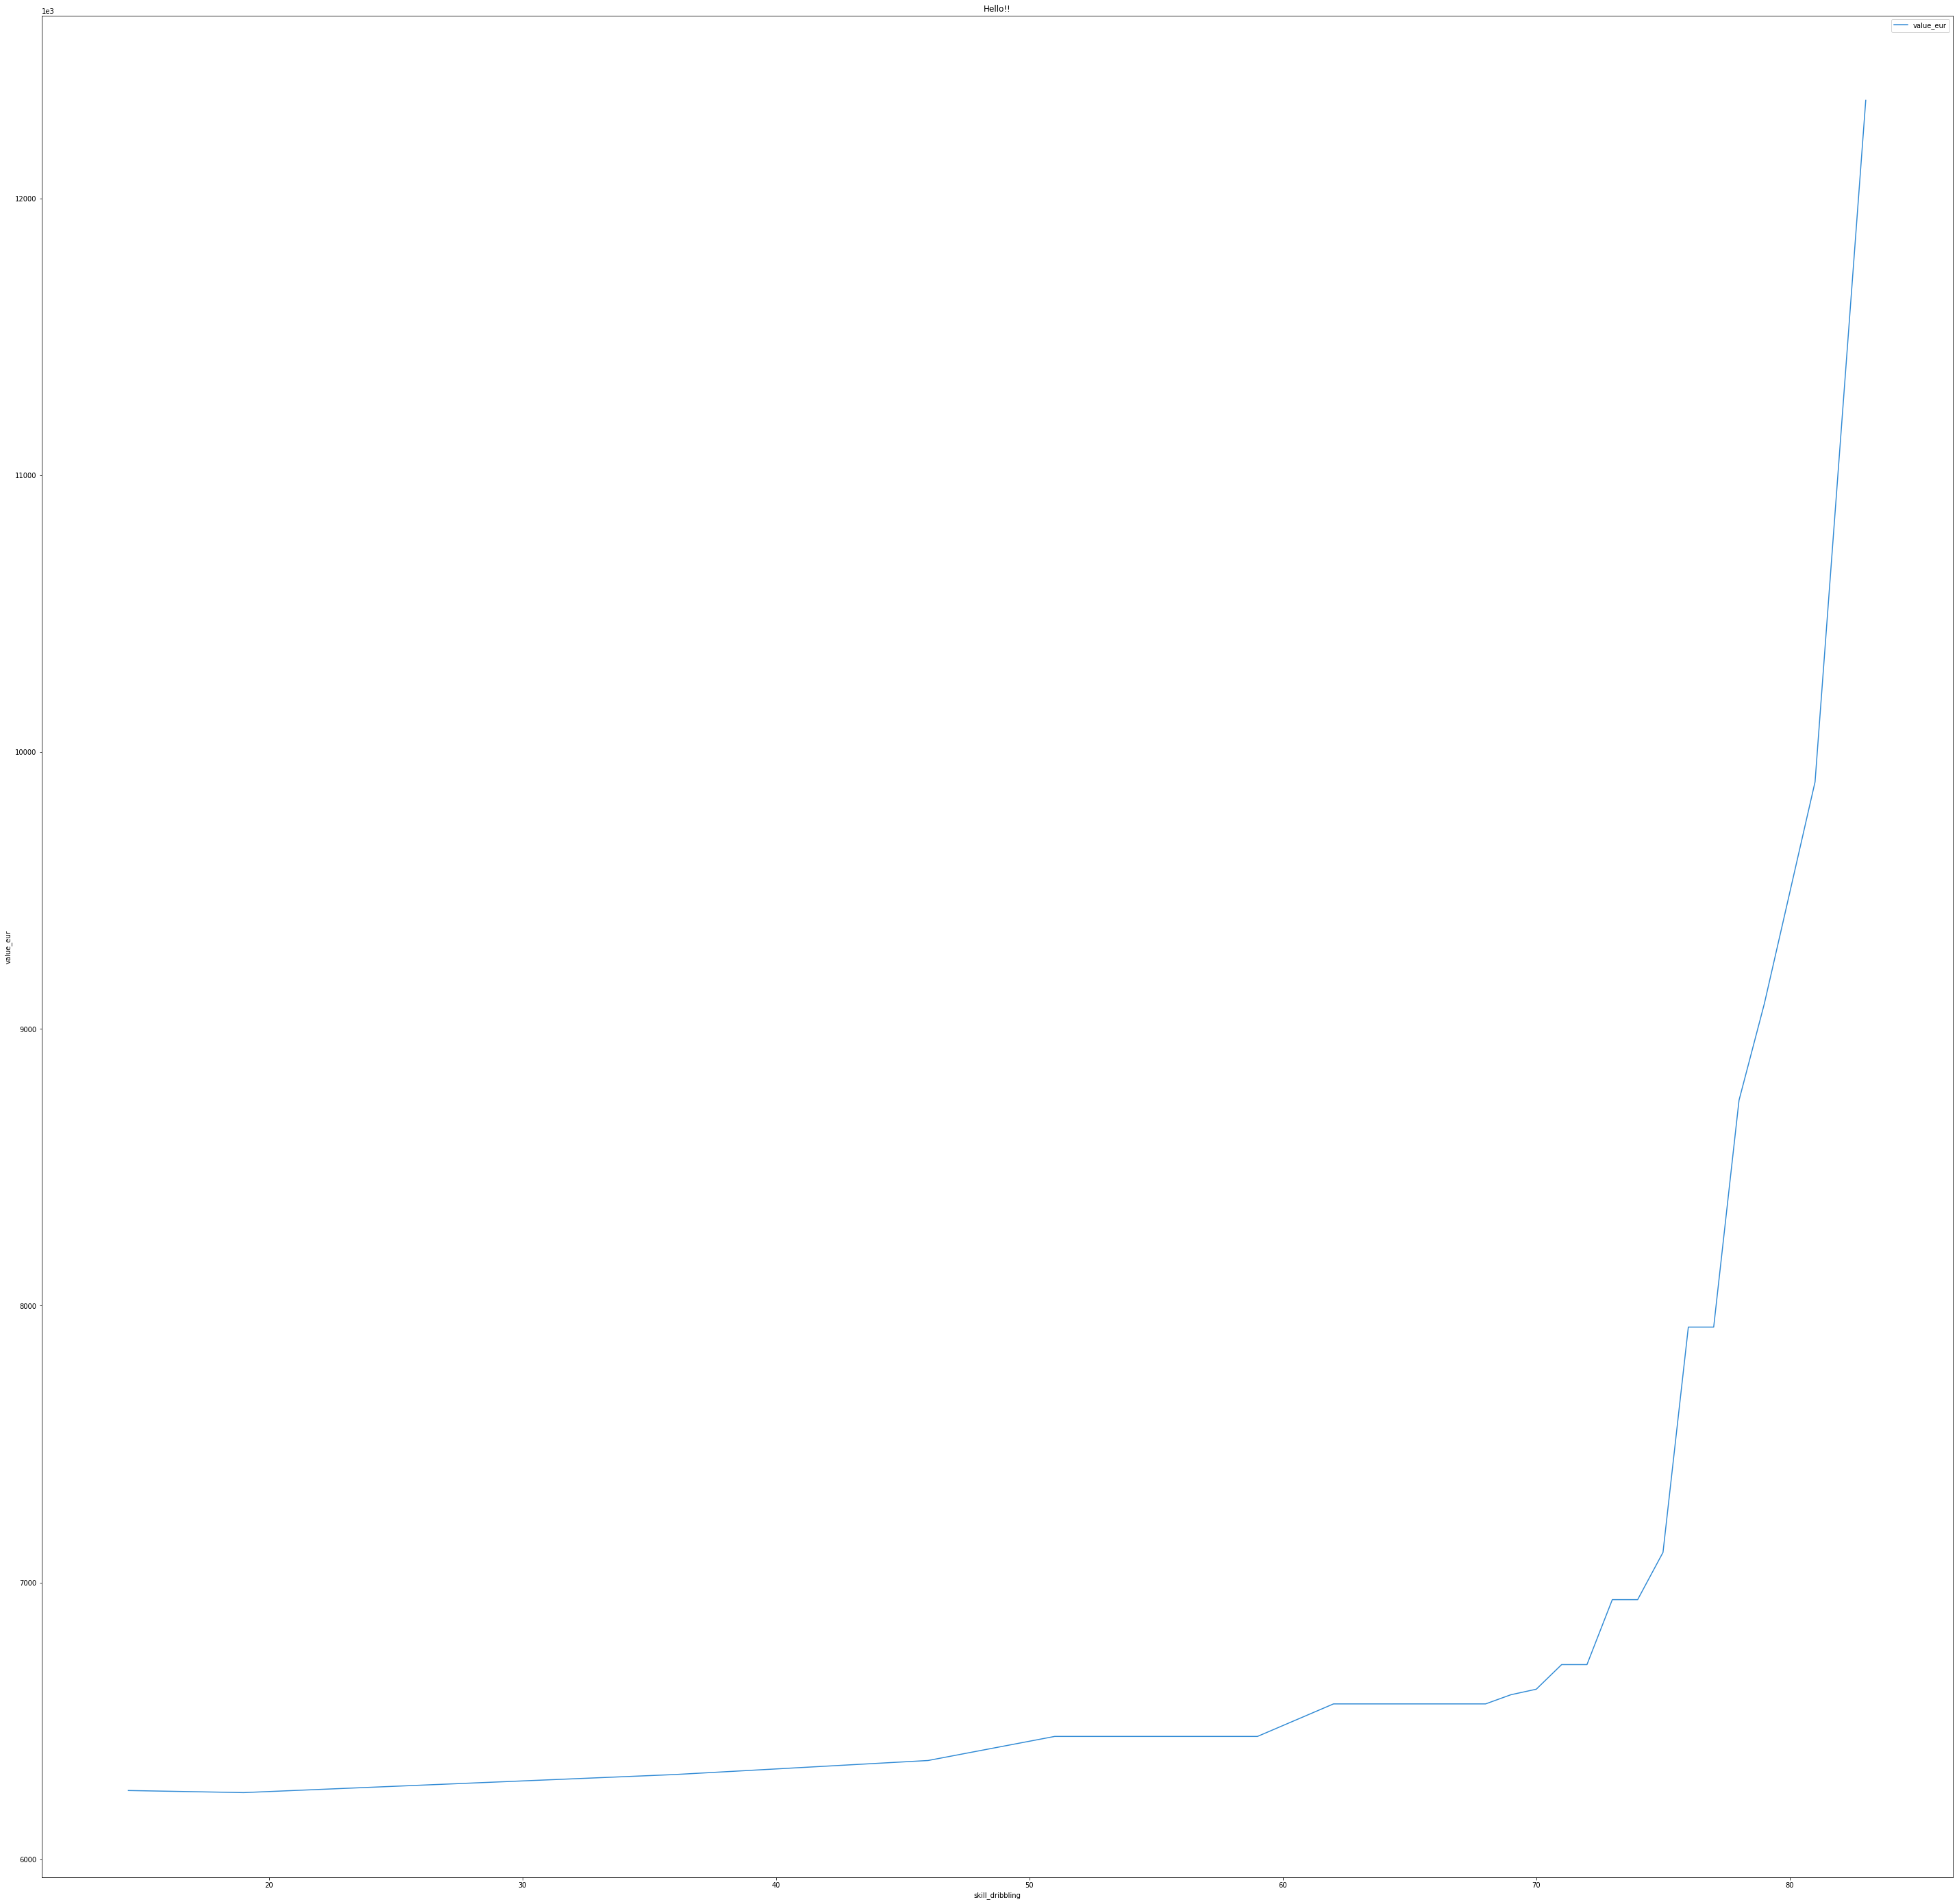

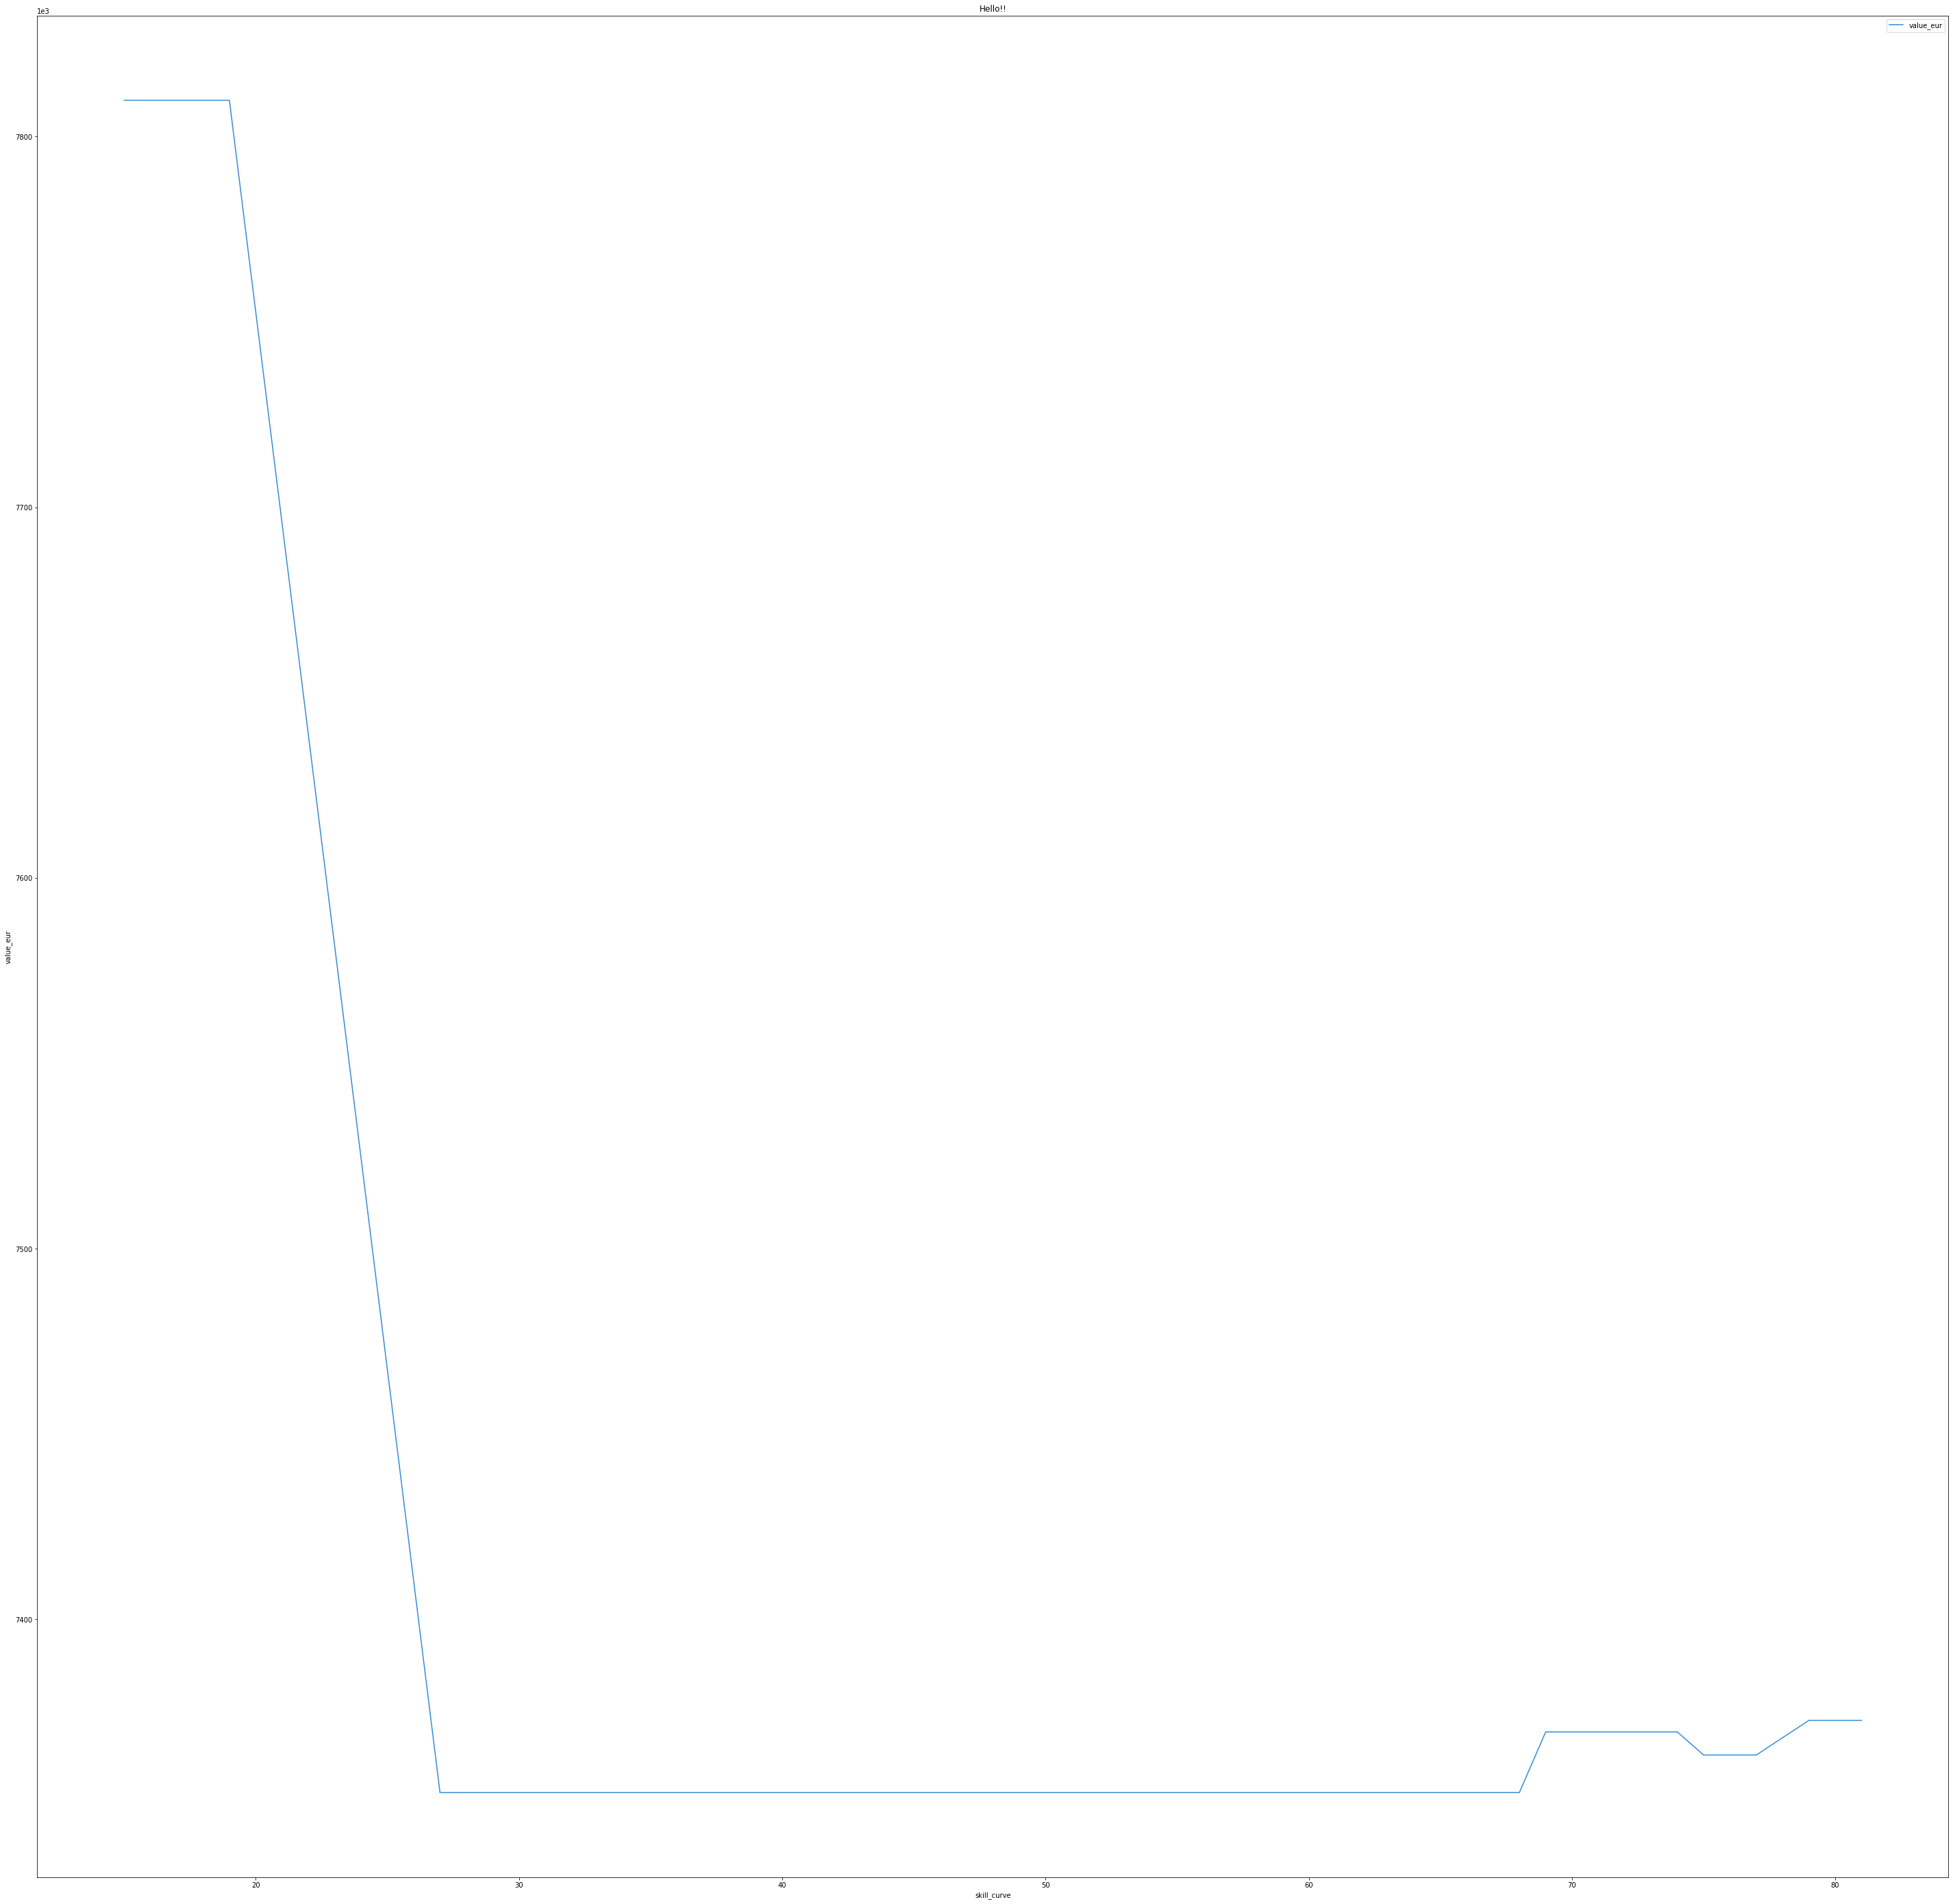

In [14]:
explainer_obj = DevExplainer(
    model_obj = model_obj,
    x_train = x_dataset,
    y_train = y_dataset,
    model_type = "Regression"
)
explainer_obj.partial_dependence_plot()
# explainer_obj.partial_dependence_values()